In [1]:
# Projet préparation des données d'un organisme de santé  : Améliorer la base de données Open Food Facts

## Importation des librairies nécessaires
import pandas as pd
import numpy as np

In [2]:
## Importation des librairies supplémentaires utiles
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy.stats as st
from sklearn.impute import SimpleImputer,MissingIndicator,KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [4]:
!pip install seaborn --upgrade

In [5]:
pip install missingno==0.5.2

Note: you may need to restart the kernel to use updated packages.


In [6]:
## Chargement des données
products = pd.read_csv("fr.openfoodfacts.org.products.csv",sep="\t",low_memory=False)

In [7]:
products.head()

code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3             usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4             usda-ndb-import  1489055653  2017-03-09T10:34:13Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   
2      1489069957   2017-03-09T14:32:37Z                         Peanuts   
3      1489055731   2017-03-09T10:35:31Z          Organic Salted Nut Mix   
4      1489055653   2017-03-09T10:34:13Z                 Organic Polenta   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   
2          NaN      NaN  ...     NaN                         NaN   
3          NaN      NaN  ...     NaN                         NaN   
4          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                              NaN        NaN             NaN   
2                              NaN        NaN             NaN   
3                              NaN        NaN             NaN   
4                              NaN        NaN             NaN   

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                    14.0                    14.0   
2                   NaN                     0.0                     0.0   
3                   NaN                    12.0                    12.0   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 162 columns]

In [8]:
print(products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB
None


# AMELIORATION DE LA BASE DE DONNEES Open Food Facts

## Choix de la thématique à proposer


L’agence Santé publique France souhaite améliorer sa base de données Open Food Facts sur la qualité nutritionnelle des produits. Cette base de données, pour chaque nouvelle entrée, est aujourd’hui alimentée manuellement par des champs textuels et numériques générant ainsi de multiples erreurs de saisie et des valeurs manquantes.

Notre objectif est de créer et implémenter un système de suggestion ou d’auto complétion qui permettrait aux usagers à remplir plus efficacement la base de données.

Plus précisément, nous souhaitons dans notre approche, apporter une solution innovante à cet objectif de santé publique d’information nutritive, d’orientation vers de produits plus sains et d’efficacité de complétion pour l’ensemble des utilisateurs de cette base de données open source.

Notre solution s’articulera ainsi :
- Champ d’actions : ensemble des produits alimentaires vendus sur le territoire français,
- Donner pour chaque produit la classe de son Nutri-Score,
- Proposer aux usagers un produit alternatif mieux classé que celui recherché.



# DOCUMENTATION SUR LE NUTRI-SCORE

## 1. Cadre réglementaire

Le règlement européen EU n°1169/2011, dit règlement INCO, établit les règles sur l’information des consommateurs, permettant ainsi d’accéder à des informations de bases tel que la déclaration nutritionnelle ou la liste des ingrédients.

A la suite de ce règlement, Santé publique France crée un système d’étiquetage nutritionnel à l’avant des emballages à la demande du Ministère des Solidarités et de la Santé c’est le Nutri-Score.

Il n’est pas obligatoire, il est développé pour faciliter la compréhension des informations nutritionnelles par les consommateurs et les aider à faire des choix éclairés.
Mis en place en France pour la première fois en 2017 suite à des travaux de recherche du Professeur Serge Hercberg et des organismes tels que l’Agence nationale de sécurité sanitaire (ANSES) et  le Haut Conseil de la Santé Publique (HCSP), son utilisation a été ensuite recommandée par plusieurs pays européens.

## 2. Qu’est-ce que c’est exactement ?

Le nutri-score c’est :
Un logo apposé en face avant des emballages qui informe sur la qualité nutritionnelle des produits sous une forme simplifiée et complémentaire à la déclaration nutritionnelle obligatoire (fixée par la réglementation européenne).
Basé sur une échelle de 5 couleurs : du vert foncé au orange foncé
Associé à des lettres allant de A à E pour optimiser son accessibilité et sa compréhension par le consommateur


## 3. Le mode de calcul

'''Le nutri-score est déterminé après l’estimation du score nutritionnel d’un aliment. Ce score nutritionnel est estimé pour 100g ou 100ml de produits en fonction de la composition en nutriments et ingrédients majeurs pour la santé. Les nutriments et ingrédients majeurs sont réunis en deux composantes. 

- Composante N (moins bonne qualité nutritionnelle) : 0 – 40 points
    • Energie (KJ)
    • Sucres (g)
    • Acides gras saturés (g)
    • Sodium (g)
    
- Composante P (meilleure qualité nutritionnelle) : 0 - 15 points
    • Fruits, légumes, légumineuses, huile de colza, de noix (%)
    • Fibres (g)
    • Protéines (g)
    
Une fois le score nutritionnel des nutriments et ingrédients majeurs déterminé, les points sont totalisés pour chaque composante et un score nutritionnel final est calculé pour l’aliment. (Total composante N – Total composante P). Certains ajustements sont cependant à prendre en compte en ce qui concerne certains aliments comme les boissons, fromages et la considération des acides gras saturés (AGS).

Sur la base de ce score nutritionnel fanal, une classification est établie (de A à E) ce qui permet de déterminer le nutri-score de l’aliment.
Les tableaux ci-dessous donnent de façon détaillée les différentes étapes de calcul ainsi que les exceptions identifiées.'''


'''Sur la base de la compréhension de la méthode de calcul du nutri-score et plus précisément des variables entrant en compte pour sa détermination, et sur la base de la problématique expliquée ci-dessus et de notre choix sur la solution à apporter, il nous semble pertinent de retenir les variables suivants qui selon nous, nous permettront de mettre en place les éléments de réponse pour la solution proposée. Il s'agit de :

- Variables contenant les informations générales sur le produit : code, url, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, categories, countries_fr.

- Variables pris en compte pour la détermination du score nutritionnel (composante N et P) : energy_100g, saturated-fat_100g, sugars_100g, fiber_100g, proteins_100g, sodium_100g, fruits-vegetables-nuts_100g.

- Variables non retenues in fine pour la solution que nous proposons mais que nous sélectionnons pour le traitement des valeurs manquantes des variables ci-dessus et la définition des familles de produits : salt_100g, carbohydrates_100g, pnns_groups_1 et pnns_groups_2.

- Variables donnant les scores nutritionnels et le nutri-score : nutrition-score-fr_100g, nutrition_grade_fr.

Soit un total de 25 varaibles estimées pertinentes pour notre solution.'''
    

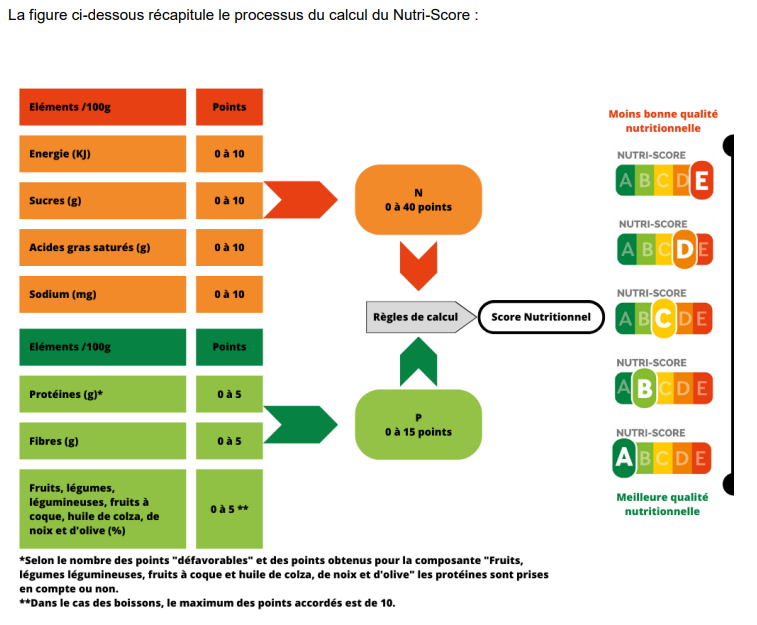

In [9]:
from IPython.display import Image
Image(filename='methodcalcul.png')

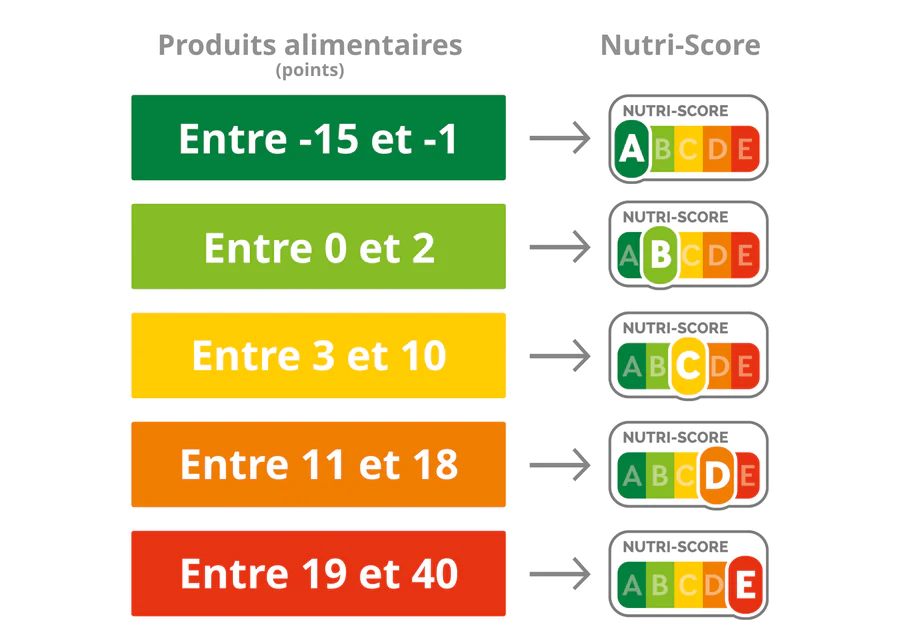

In [10]:
Image(filename='synthesescore.png')

In [11]:
# Notre jeu de données de base est celui-ci compte tenu des précisions données ci-dessus :

products = products.loc[:,["code","url","created_t","created_datetime","last_modified_t",
                           "last_modified_datetime","product_name","generic_name","quantity","categories",
                           "countries_fr","nutrition_grade_fr","pnns_groups_1","pnns_groups_2",
                           "energy_100g","fat_100g","carbohydrates_100g","saturated-fat_100g","sugars_100g",
                           "fiber_100g","proteins_100g","salt_100g","sodium_100g","fruits-vegetables-nuts_100g",
                           "nutrition-score-fr_100g",]]
products.head()

code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   

    created_t      created_datetime last_modified_t last_modified_datetime  \
0  1474103866  2016-09-17T09:17:46Z      1474103893   2016-09-17T09:18:13Z   
1  1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z   
2  1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z   
3  1489055731  2017-03-09T10:35:31Z      1489055731   2017-03-09T10:35:31Z   
4  1489055653  2017-03-09T10:34:13Z      1489055653   2017-03-09T10:34:13Z   

                     product_name generic_name quantity categories  ...  \
0              Farine de blé noir          NaN      1kg        NaN  ...   
1  Banana Chips Sweetened (Whole)          NaN      NaN        NaN  ...   
2                         Peanuts          NaN      NaN        NaN  ...   
3          Organic Salted Nut Mix          NaN      NaN        NaN  ...   
4                 Organic Polenta          NaN      NaN        NaN  ...   

  fat_100g carbohydrates_100g saturated-fat_100g sugars_100g  fiber_100g  \
0      NaN                NaN                NaN         NaN         NaN   
1    28.57              64.29              28.57       14.29         3.6   
2    17.86              60.71               0.00       17.86         7.1   
3    57.14              17.86               5.36        3.57         7.1   
4     1.43              77.14                NaN         NaN         5.7   

   proteins_100g  salt_100g  sodium_100g  fruits-vegetables-nuts_100g  \
0            NaN        NaN          NaN                          NaN   
1           3.57    0.00000        0.000                          NaN   
2          17.86    0.63500        0.250                          NaN   
3          17.86    1.22428        0.482                          NaN   
4           8.57        NaN          NaN                          NaN   

   nutrition-score-fr_100g  
0                      NaN  
1                     14.0  
2                      0.0  
3                     12.0  
4                      NaN  

[5 rows x 25 columns]

In [12]:
products.shape

(320772, 25)

In [13]:
products_selected_nutrients = products.loc[:,['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','fruits-vegetables-nuts_100g']]

In [14]:
products_selected_nutrients

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
0               NaN                 NaN          NaN         NaN   
1            2243.0               28.57        14.29         3.6   
2            1941.0                0.00        17.86         7.1   
3            2540.0                5.36         3.57         7.1   
4            1552.0                 NaN          NaN         5.7   
...             ...                 ...          ...         ...   
320767          NaN                 NaN          NaN         NaN   
320768          0.0                0.00         0.00         0.0   
320769          NaN                 NaN          NaN         NaN   
320770          NaN                 NaN          NaN         NaN   
320771       2092.0                 NaN         0.00         NaN   

        proteins_100g  sodium_100g  fruits-vegetables-nuts_100g  
0                 NaN          NaN                          NaN  
1                3.57        0.000                          NaN  
2               17.86        0.250                          NaN  
3               17.86        0.482                          NaN  
4                8.57          NaN                          NaN  
...               ...          ...                          ...  
320767            NaN          NaN                          NaN  
320768           0.00        0.000                          NaN  
320769            NaN          NaN                          NaN  
320770            NaN          NaN                          NaN  
320771           0.00        0.000                          NaN  

[320772 rows x 7 columns]

In [15]:
products_selected_nutrients["Filling_rate"] = round(products_selected_nutrients.notnull().mean(axis=1)*100,0)

In [16]:
products_selected_nutrients

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
0               NaN                 NaN          NaN         NaN   
1            2243.0               28.57        14.29         3.6   
2            1941.0                0.00        17.86         7.1   
3            2540.0                5.36         3.57         7.1   
4            1552.0                 NaN          NaN         5.7   
...             ...                 ...          ...         ...   
320767          NaN                 NaN          NaN         NaN   
320768          0.0                0.00         0.00         0.0   
320769          NaN                 NaN          NaN         NaN   
320770          NaN                 NaN          NaN         NaN   
320771       2092.0                 NaN         0.00         NaN   

        proteins_100g  sodium_100g  fruits-vegetables-nuts_100g  Filling_rate  
0                 NaN          NaN                          NaN           0.0  
1                3.57        0.000                          NaN          86.0  
2               17.86        0.250                          NaN          86.0  
3               17.86        0.482                          NaN          86.0  
4                8.57          NaN                          NaN          43.0  
...               ...          ...                          ...           ...  
320767            NaN          NaN                          NaN           0.0  
320768           0.00        0.000                          NaN          86.0  
320769            NaN          NaN                          NaN           0.0  
320770            NaN          NaN                          NaN           0.0  
320771           0.00        0.000                          NaN          57.0  

[320772 rows x 8 columns]

In [17]:
# Nous choisissons de ne analyser que les produits ayant au moins 3 des valeurs majeures des  nutriments renseignés soit 43% de taux de remplissage.

products_analysed = products_selected_nutrients.loc[products_selected_nutrients['Filling_rate']>=43,:]
products_analysed

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
1            2243.0               28.57        14.29         3.6   
2            1941.0                0.00        17.86         7.1   
3            2540.0                5.36         3.57         7.1   
4            1552.0                 NaN          NaN         5.7   
5            1933.0                1.92        11.54         7.7   
...             ...                 ...          ...         ...   
320756        569.0                 NaN         9.60         1.1   
320757       2406.0                3.73         3.89        12.2   
320763         21.0                0.20         0.50         0.2   
320768          0.0                0.00         0.00         0.0   
320771       2092.0                 NaN         0.00         NaN   

        proteins_100g  sodium_100g  fruits-vegetables-nuts_100g  Filling_rate  
1                3.57     0.000000                          NaN          86.0  
2               17.86     0.250000                          NaN          86.0  
3               17.86     0.482000                          NaN          86.0  
4                8.57          NaN                          NaN          43.0  
5               13.46          NaN                          NaN          71.0  
...               ...          ...                          ...           ...  
320756           2.10     0.433071                          NaN          71.0  
320757          21.22     0.039370                          NaN          86.0  
320763           0.50     0.010000                          NaN          86.0  
320768           0.00     0.000000                          NaN          86.0  
320771           0.00     0.000000                          NaN          57.0  

[256985 rows x 8 columns]

In [18]:
# reconstruction de notre base de produits à analyser
data_products = products_analysed.copy()
data_products['code'] = products['code']
data_products['url'] = products['url']
data_products['created_t'] = products['created_t']
data_products['created_datetime'] = products['created_datetime']
data_products['last_modified_t'] = products['last_modified_t']
data_products['last_modified_datetime'] = products['last_modified_datetime']
data_products['product_name'] = products['product_name']
data_products['generic_name'] = products['generic_name']
data_products['quantity'] = products['quantity']
data_products['categories'] = products['categories']
data_products['countries_fr'] = products['countries_fr']
data_products['fat_100g'] = products['fat_100g']
data_products['carbohydrates_100g'] = products['carbohydrates_100g']
data_products['salt_100g'] = products['salt_100g']
data_products['pnns_groups_1'] = products['pnns_groups_1']
data_products['pnns_groups_2'] = products['pnns_groups_2']
data_products['nutrition-score-fr_100g'] = products['nutrition-score-fr_100g']
data_products['nutrition_grade_fr'] = products['nutrition_grade_fr']
data_products.head()

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
1       2243.0               28.57        14.29         3.6           3.57   
2       1941.0                0.00        17.86         7.1          17.86   
3       2540.0                5.36         3.57         7.1          17.86   
4       1552.0                 NaN          NaN         5.7           8.57   
5       1933.0                1.92        11.54         7.7          13.46   

   sodium_100g  fruits-vegetables-nuts_100g  Filling_rate           code  \
1        0.000                          NaN          86.0  0000000004530   
2        0.250                          NaN          86.0  0000000004559   
3        0.482                          NaN          86.0  0000000016087   
4          NaN                          NaN          43.0  0000000016094   
5          NaN                          NaN          71.0  0000000016100   

                                                 url  ... quantity categories  \
1  http://world-fr.openfoodfacts.org/produit/0000...  ...      NaN        NaN   
2  http://world-fr.openfoodfacts.org/produit/0000...  ...      NaN        NaN   
3  http://world-fr.openfoodfacts.org/produit/0000...  ...      NaN        NaN   
4  http://world-fr.openfoodfacts.org/produit/0000...  ...      NaN        NaN   
5  http://world-fr.openfoodfacts.org/produit/0000...  ...      NaN        NaN   

  countries_fr fat_100g carbohydrates_100g salt_100g pnns_groups_1  \
1   États-Unis    28.57              64.29   0.00000           NaN   
2   États-Unis    17.86              60.71   0.63500           NaN   
3   États-Unis    57.14              17.86   1.22428           NaN   
4   États-Unis     1.43              77.14       NaN           NaN   
5   États-Unis    18.27              63.46       NaN           NaN   

  pnns_groups_2 nutrition-score-fr_100g  nutrition_grade_fr  
1           NaN                    14.0                   d  
2           NaN                     0.0                   b  
3           NaN                    12.0                   d  
4           NaN                     NaN                 NaN  
5           NaN                     NaN                 NaN  

[5 rows x 26 columns]

In [19]:
data = data_products.loc[:,['code','url','created_t','created_datetime','last_modified_t','last_modified_datetime','product_name',
                            'generic_name','quantity','categories','countries_fr','energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g',
                            'fiber_100g','proteins_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g','pnns_groups_1','pnns_groups_2',
                           'nutrition-score-fr_100g','nutrition_grade_fr']]
data.head()

code                                                url  \
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2  0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3  0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
4  0000000016094  http://world-fr.openfoodfacts.org/produit/0000...   
5  0000000016100  http://world-fr.openfoodfacts.org/produit/0000...   

    created_t      created_datetime last_modified_t last_modified_datetime  \
1  1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z   
2  1489069957  2017-03-09T14:32:37Z      1489069957   2017-03-09T14:32:37Z   
3  1489055731  2017-03-09T10:35:31Z      1489055731   2017-03-09T10:35:31Z   
4  1489055653  2017-03-09T10:34:13Z      1489055653   2017-03-09T10:34:13Z   
5  1489055651  2017-03-09T10:34:11Z      1489055651   2017-03-09T10:34:11Z   

                        product_name generic_name quantity categories  ...  \
1     Banana Chips Sweetened (Whole)          NaN      NaN        NaN  ...   
2                            Peanuts          NaN      NaN        NaN  ...   
3             Organic Salted Nut Mix          NaN      NaN        NaN  ...   
4                    Organic Polenta          NaN      NaN        NaN  ...   
5  Breadshop Honey Gone Nuts Granola          NaN      NaN        NaN  ...   

  sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
1       14.29         3.6           3.57    0.00000        0.000   
2       17.86         7.1          17.86    0.63500        0.250   
3        3.57         7.1          17.86    1.22428        0.482   
4         NaN         5.7           8.57        NaN          NaN   
5       11.54         7.7          13.46        NaN          NaN   

   fruits-vegetables-nuts_100g  pnns_groups_1  pnns_groups_2  \
1                          NaN            NaN            NaN   
2                          NaN            NaN            NaN   
3                          NaN            NaN            NaN   
4                          NaN            NaN            NaN   
5                          NaN            NaN            NaN   

   nutrition-score-fr_100g  nutrition_grade_fr  
1                     14.0                   d  
2                      0.0                   b  
3                     12.0                   d  
4                      NaN                 NaN  
5                      NaN                 NaN  

[5 rows x 25 columns]

# Filtrer pour ne retenir que les produits vendus en France :

In [20]:
data = data.loc[data['countries_fr'].str.contains('France', case=False, na=False),:]
data.head()

code                                                url  \
106  0000000036252  http://world-fr.openfoodfacts.org/produit/0000...   
138  0000000039529  http://world-fr.openfoodfacts.org/produit/0000...   
190  0000010187319  http://world-fr.openfoodfacts.org/produit/0000...   
191  0000010207260  http://world-fr.openfoodfacts.org/produit/0000...   
226  0000040608754  http://world-fr.openfoodfacts.org/produit/0000...   

      created_t      created_datetime last_modified_t last_modified_datetime  \
106  1422221701  2015-01-25T21:35:01Z      1489055667   2017-03-09T10:34:27Z   
138  1420147051  2015-01-01T21:17:31Z      1489055652   2017-03-09T10:34:12Z   
190  1487325954  2017-02-17T10:05:54Z      1487325954   2017-02-17T10:05:54Z   
191  1490203031  2017-03-22T17:17:11Z      1490203757   2017-03-22T17:29:17Z   
226  1345024108  2012-08-15T09:48:28Z      1439141731   2015-08-09T17:35:31Z   

                   product_name  \
106              Lion Peanut x2   
138              Pack de 2 Twix   
190              Mini Confettis   
191  Praliné Amande Et Noisette   
226       Pepsi, Nouveau goût !   

                                          generic_name quantity  \
106                                                NaN      NaN   
138                                                NaN      NaN   
190                                                NaN      NaN   
191                                                NaN      NaN   
226  Boisson gazeuse rafraîchissante aux extraits n...    15 cl   

        categories  ... sugars_100g  fiber_100g  proteins_100g  salt_100g  \
106            NaN  ...        57.5         2.5           2.50    0.09652   
138            NaN  ...         NaN         6.2           6.25        NaN   
190            NaN  ...        87.7         0.9           0.60    0.01000   
191            NaN  ...        50.3         3.9           9.50    0.00300   
226  Sodas au cola  ...        10.4         0.0           0.00    0.02540   

     sodium_100g  fruits-vegetables-nuts_100g  pnns_groups_1  \
106     0.038000                          NaN        unknown   
138          NaN                          NaN        unknown   
190     0.003937                          NaN            NaN   
191     0.001181                          NaN            NaN   
226     0.010000                          NaN      Beverages   

           pnns_groups_2  nutrition-score-fr_100g  nutrition_grade_fr  
106              unknown                     22.0                   e  
138              unknown                      NaN                 NaN  
190                  NaN                     14.0                   d  
191                  NaN                     14.0                   d  
226  Sweetened beverages                     13.0                   e  

[5 rows x 25 columns]

In [21]:
# Recherche de doublonns : Un code produit est il présent plusieurs fois dans le jeu de données?

data.duplicated(["code"], keep = False)

106       False
138       False
190       False
191       False
226       False
          ...  
320740    False
320741    False
320751    False
320757    False
320763    False
Length: 62959, dtype: bool

In [22]:
# Affichage des doublons

data[data.duplicated(["code"])]

Empty DataFrame
Columns: [code, url, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, categories, countries_fr, energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, fruits-vegetables-nuts_100g, pnns_groups_1, pnns_groups_2, nutrition-score-fr_100g, nutrition_grade_fr]
Index: []

[0 rows x 25 columns]

In [23]:
# Observation globale du niveau de complétude et du type des données

print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 62959 entries, 106 to 320763
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         62959 non-null  object 
 1   url                          62959 non-null  object 
 2   created_t                    62959 non-null  object 
 3   created_datetime             62958 non-null  object 
 4   last_modified_t              62959 non-null  object 
 5   last_modified_datetime       62959 non-null  object 
 6   product_name                 62595 non-null  object 
 7   generic_name                 30741 non-null  object 
 8   quantity                     47079 non-null  object 
 9   categories                   45945 non-null  object 
 10  countries_fr                 62959 non-null  object 
 11  energy_100g                  62917 non-null  float64
 12  fat_100g                     45701 non-null  float64
 13  saturated-fat_100g

In [24]:
# Tableau des valeurs manquantes par variables

missing_values = data.isnull().sum()
missing_percent = round((missing_values/len(data))*100,3)
missing_table = pd.DataFrame({"Missing Values":missing_values,"Percentage":missing_percent})
print(missing_table)

                             Missing Values  Percentage
code                                      0       0.000
url                                       0       0.000
created_t                                 0       0.000
created_datetime                          1       0.002
last_modified_t                           0       0.000
last_modified_datetime                    0       0.000
product_name                            364       0.578
generic_name                          32218      51.173
quantity                              15880      25.223
categories                            17014      27.024
countries_fr                              0       0.000
energy_100g                              42       0.067
fat_100g                              17258      27.411
saturated-fat_100g                      600       0.953
carbohydrates_100g                    17311      27.496
sugars_100g                             543       0.862
fiber_100g                            17243     

<Axes: >

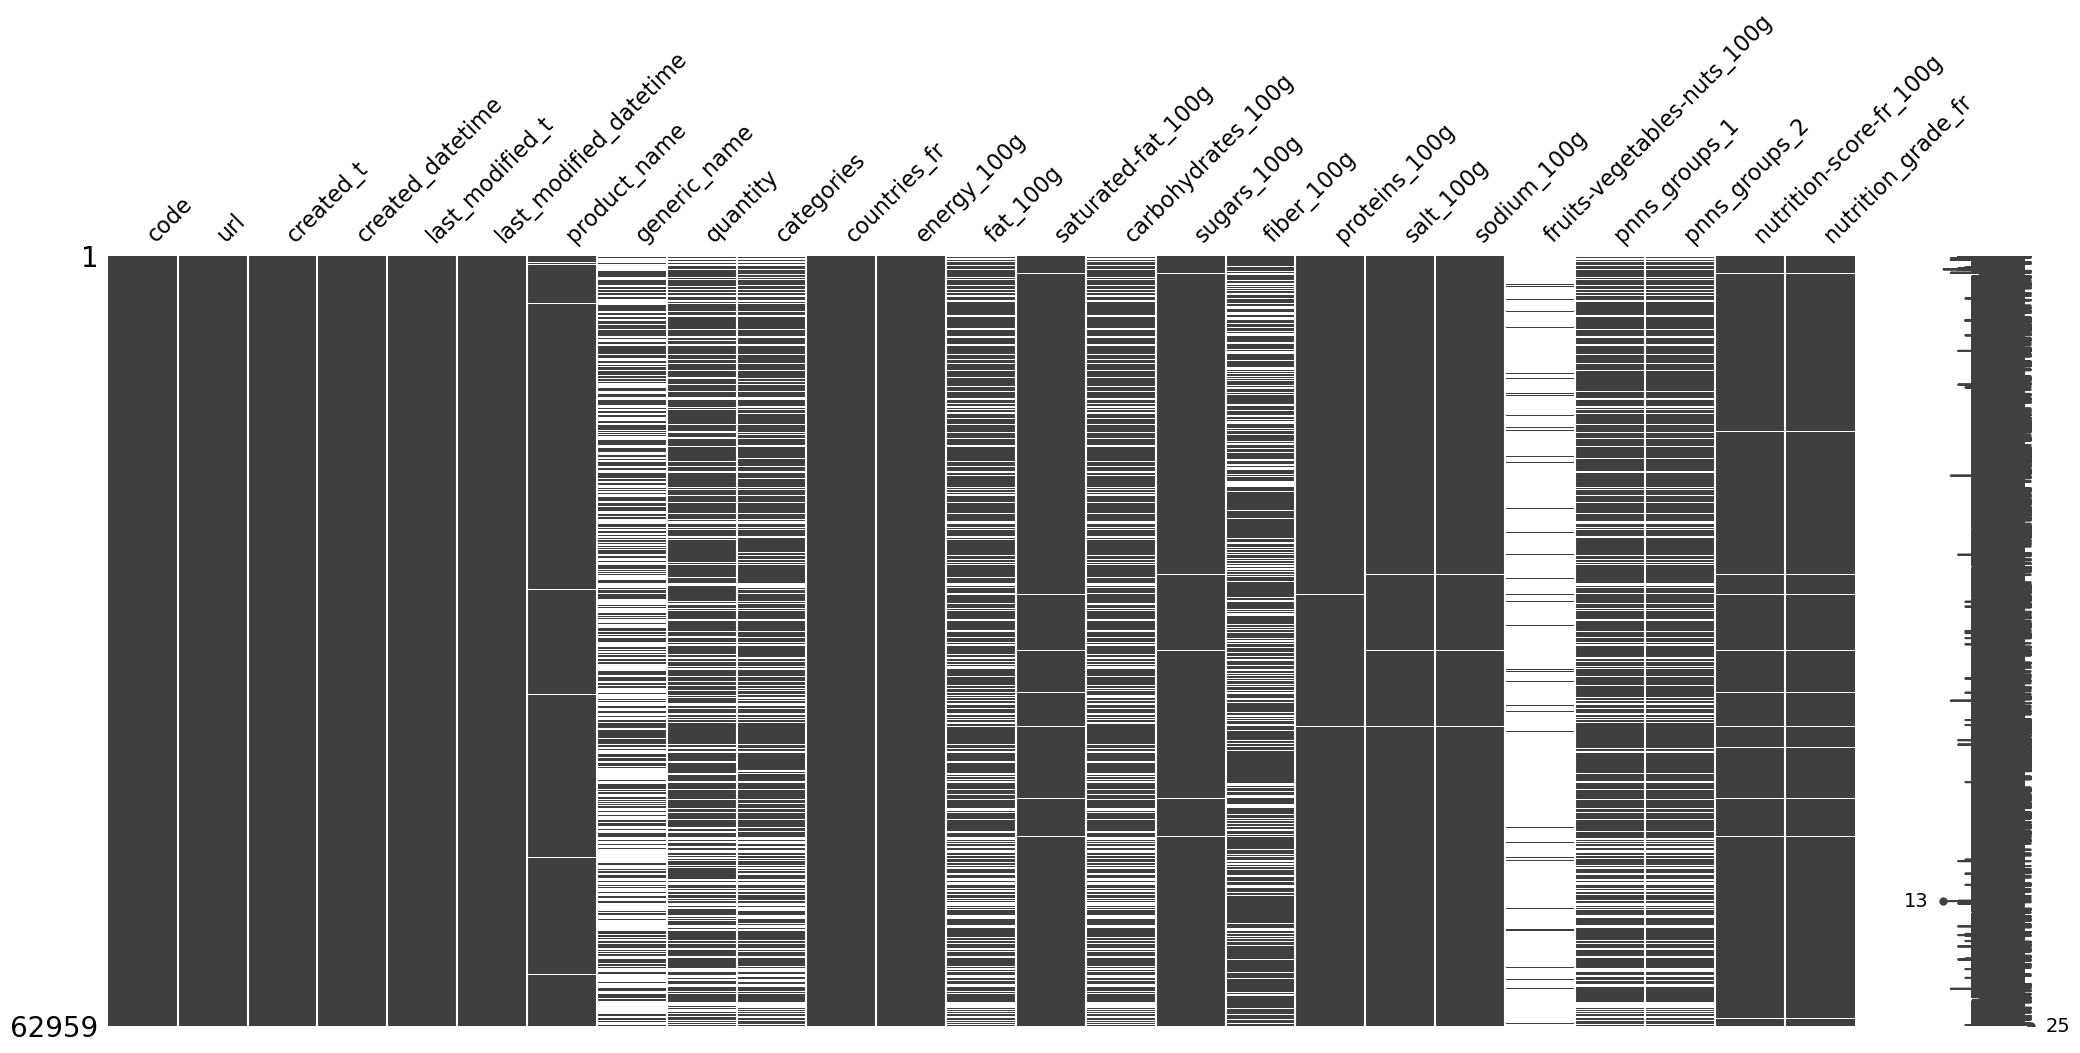

In [25]:
# Visualisation des valeurs manquantes avec missingno

msno.matrix(data)


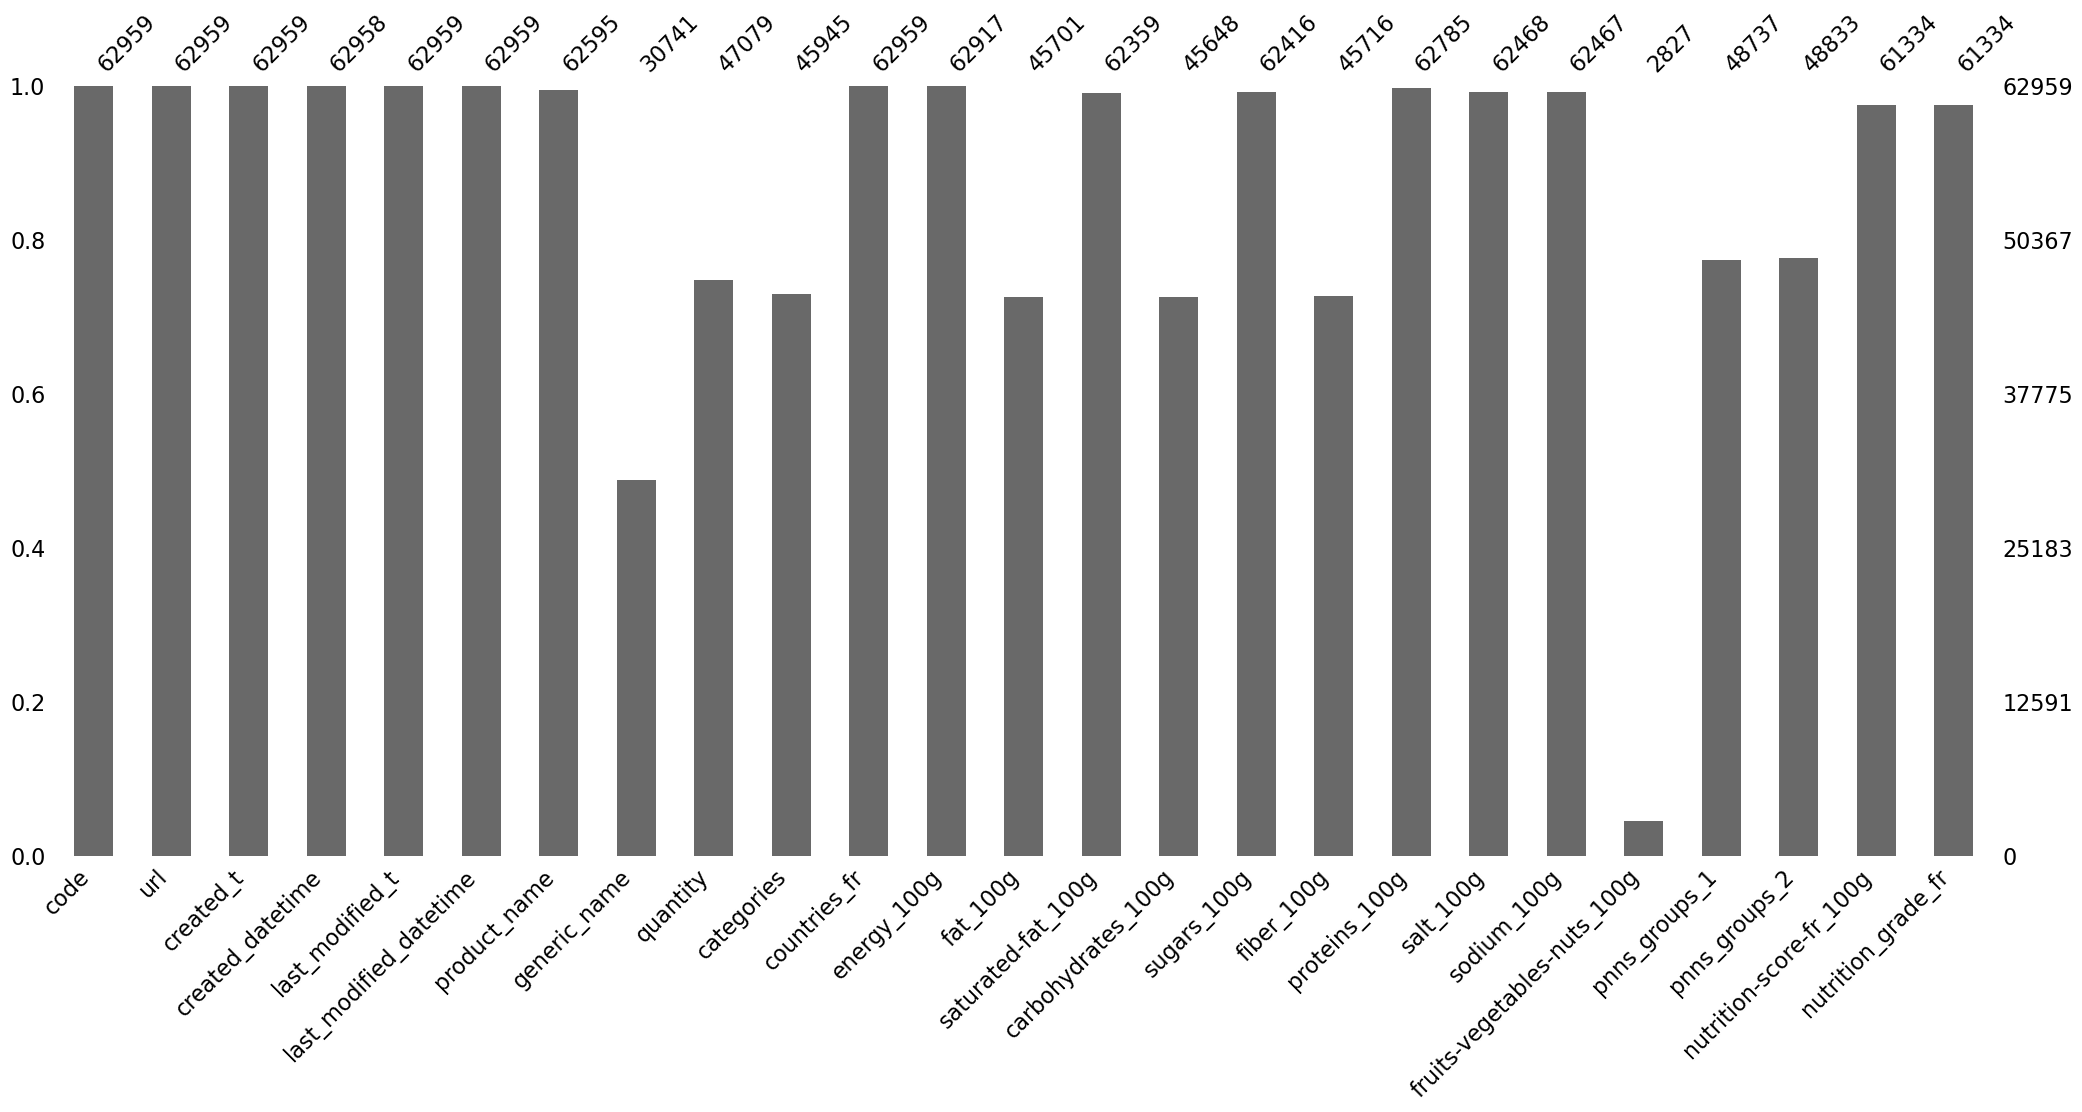

In [26]:
msno.bar(data)
plt.show()

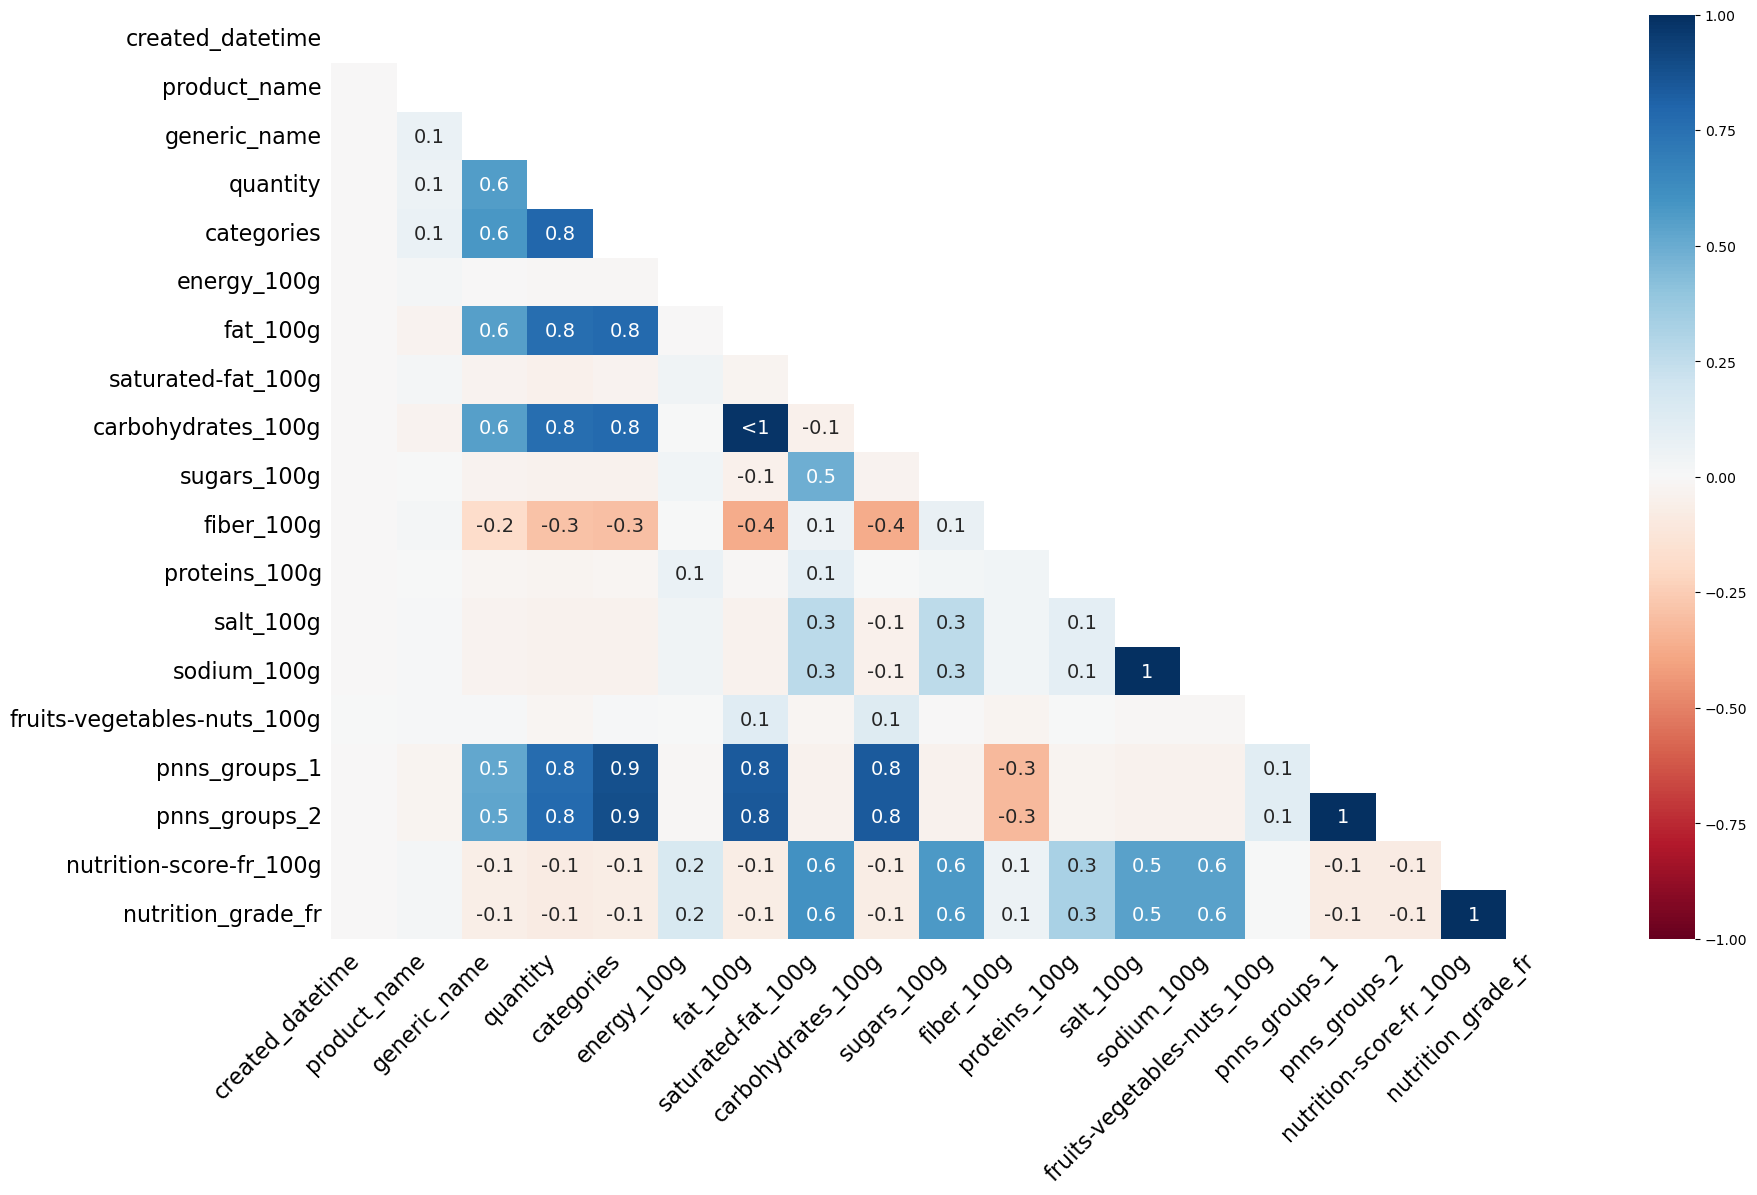

In [27]:
msno.heatmap(data)
plt.show()

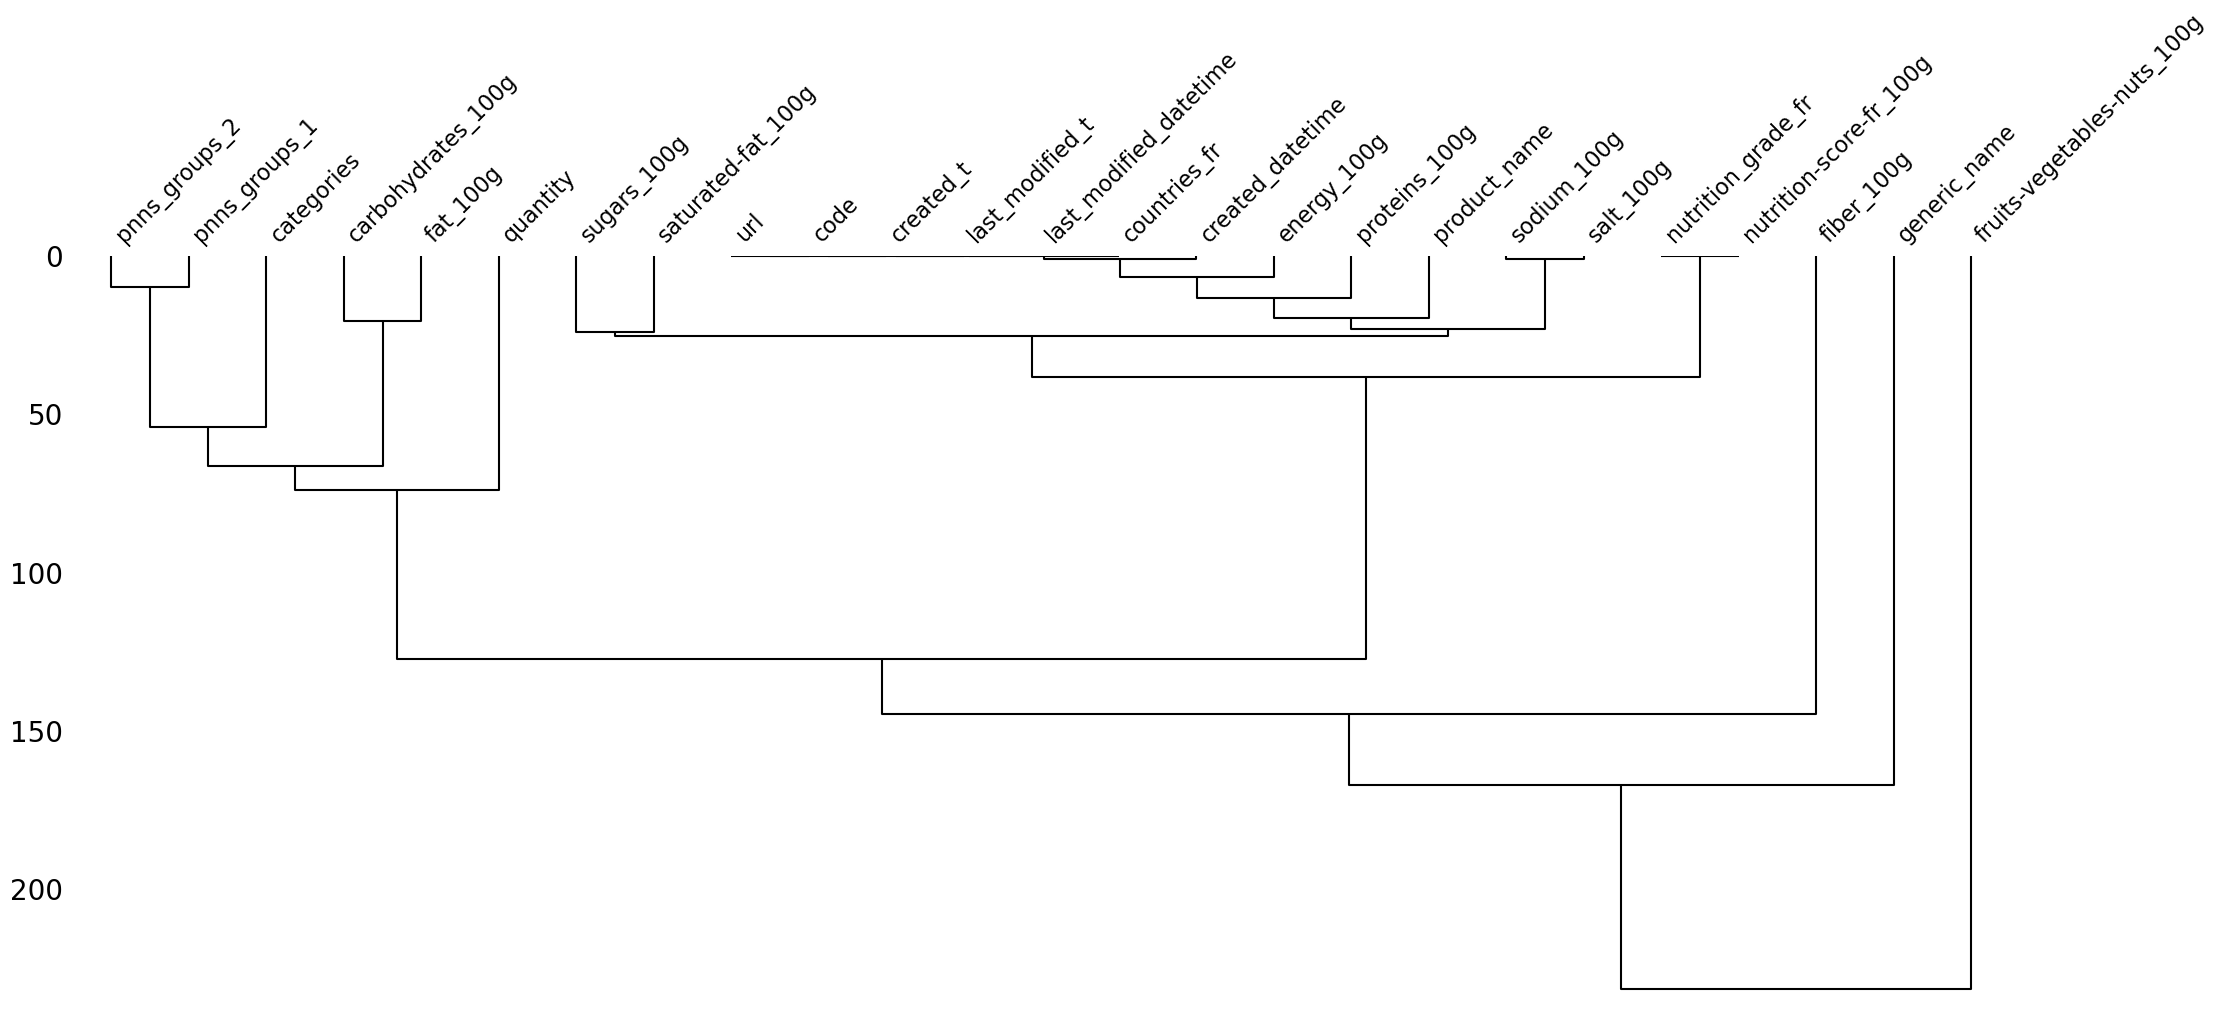

In [28]:
# Analyse des corrélations entre les valeurs manquantes

msno.dendrogram(data)
plt.show()

C:\Users\tykap\AppData\Local\Temp\ipykernel_9732\581664333.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_proportions.index, rotation=90)


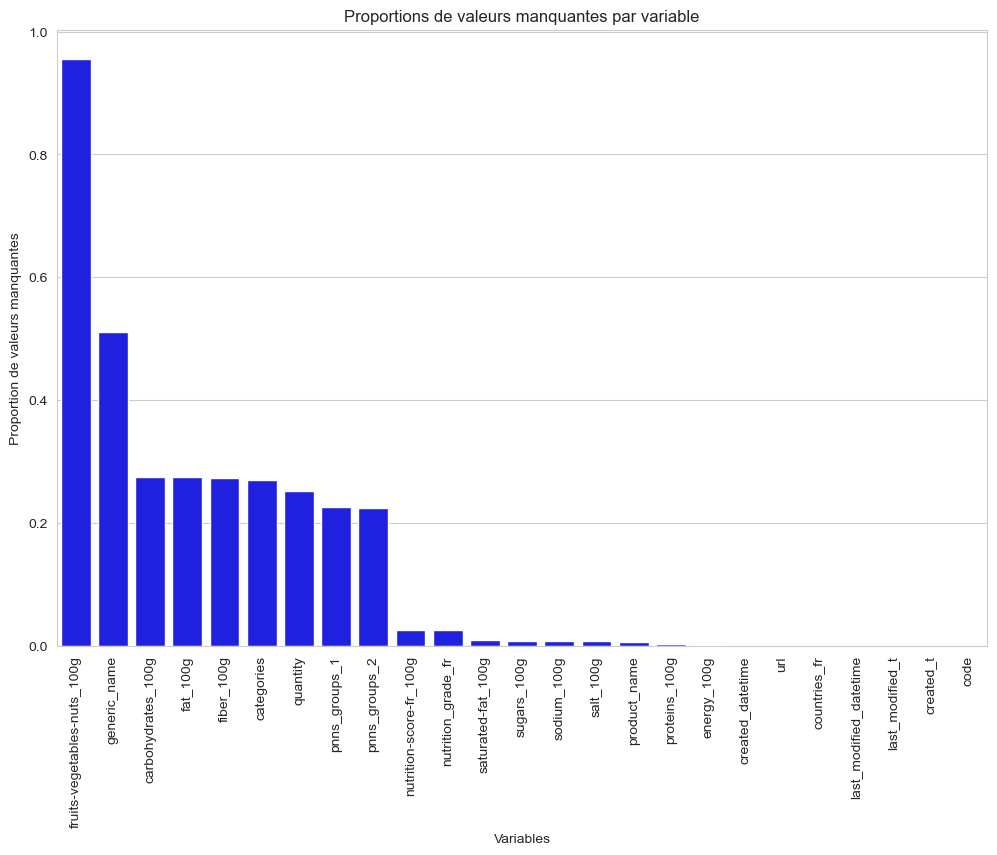

In [29]:
# Calcul et visualisation de la proportion des valeurs manquantes pour chaque varaible

missing_proportions = data.isnull().mean().sort_values(ascending=False)

# Création du graphique avec Seaborn
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=missing_proportions.index, y=missing_proportions.values, ax=ax, color='blue')
ax.set_xlabel('Variables')
ax.set_ylabel('Proportion de valeurs manquantes')
ax.set_xticklabels(missing_proportions.index, rotation=90)
ax.set_title('Proportions de valeurs manquantes par variable')
plt.show()

In [30]:
data.reset_index(drop=True)
data

code                                                url  \
106     0000000036252  http://world-fr.openfoodfacts.org/produit/0000...   
138     0000000039529  http://world-fr.openfoodfacts.org/produit/0000...   
190     0000010187319  http://world-fr.openfoodfacts.org/produit/0000...   
191     0000010207260  http://world-fr.openfoodfacts.org/produit/0000...   
226     0000040608754  http://world-fr.openfoodfacts.org/produit/0000...   
...               ...                                                ...   
320740  9782211109758  http://world-fr.openfoodfacts.org/produit/9782...   
320741  9782401029101  http://world-fr.openfoodfacts.org/produit/9782...   
320751  9847548283004  http://world-fr.openfoodfacts.org/produit/9847...   
320757  9900000000233  http://world-fr.openfoodfacts.org/produit/9900...   
320763       99111250  http://world-fr.openfoodfacts.org/produit/9911...   

         created_t      created_datetime last_modified_t  \
106     1422221701  2015-01-25T21:35:01Z      1489055667   
138     1420147051  2015-01-01T21:17:31Z      1489055652   
190     1487325954  2017-02-17T10:05:54Z      1487325954   
191     1490203031  2017-03-22T17:17:11Z      1490203757   
226     1345024108  2012-08-15T09:48:28Z      1439141731   
...            ...                   ...             ...   
320740  1489003558  2017-03-08T20:05:58Z      1489003558   
320741  1491508021  2017-04-06T19:47:01Z      1491508021   
320751  1437817626  2015-07-25T09:47:06Z      1442237848   
320757  1491079938  2017-04-01T20:52:18Z      1491079939   
320763  1367163039  2013-04-28T15:30:39Z      1371690556   

       last_modified_datetime                         product_name  \
106      2017-03-09T10:34:27Z                       Lion Peanut x2   
138      2017-03-09T10:34:12Z                       Pack de 2 Twix   
190      2017-02-17T10:05:54Z                       Mini Confettis   
191      2017-03-22T17:29:17Z           Praliné Amande Et Noisette   
226      2015-08-09T17:35:31Z                Pepsi, Nouveau goût !   
...                       ...                                  ...   
320740   2017-03-08T20:05:58Z           Verrine Cheescake Myrtille   
320741   2017-04-06T19:47:01Z                         Fiche Brevet   
320751   2015-09-14T13:37:28Z  Tartines craquantes bio au sarrasin   
320757   2017-04-01T20:52:19Z                              Amandes   
320763   2013-06-20T01:09:16Z                   Thé vert Earl grey   

                                             generic_name quantity  \
106                                                   NaN      NaN   
138                                                   NaN      NaN   
190                                                   NaN      NaN   
191                                                   NaN      NaN   
226     Boisson gazeuse rafraîchissante aux extraits n...    15 cl   
...                                                   ...      ...   
320740                                                NaN      NaN   
320741                                                NaN      NaN   
320751                                                NaN      NaN   
320757                                                NaN      NaN   
320763                                  thé bio équitable     50 g   

                             categories  ... sugars_100g  fiber_100g  \
106                                 NaN  ...       57.50         2.5   
138                                 NaN  ...         NaN         6.2   
190                                 NaN  ...       87.70         0.9   
191                                 NaN  ...       50.30         3.9   
226                       Sodas au cola  ...       10.40         0.0   
...                                 ...  ...         ...         ...   
320740                              NaN  ...       10.50         0.0   
320741                              NaN  ...        1.00        10.0   
320751  Biscottes au sarrasin,Biscottes  ...        2

In [31]:
# Harmonisation des observations du pnns_groups_1
data['pnns_groups_1'].unique()

array(['unknown', nan, 'Beverages', 'Sugary snacks', 'Composite foods',
       'Fruits and vegetables', 'Milk and dairy products',
       'Fat and sauces', 'Salty snacks', 'Cereals and potatoes',
       'Fish Meat Eggs', 'fruits-and-vegetables', 'sugary-snacks',
       'cereals-and-potatoes'], dtype=object)

In [32]:
data.loc[data['pnns_groups_1']=='cereals-and-potatoes','pnns_groups_1']='Cereals and potatoes'
data.loc[data['pnns_groups_1']=='sugary-snacks','pnns_groups_1']='Sugary snacks'
data.loc[data['pnns_groups_1']=='fruits-and-vegetables','pnns_groups_1']='Fruits and vegetables'

data['pnns_groups_1'].unique()

array(['unknown', nan, 'Beverages', 'Sugary snacks', 'Composite foods',
       'Fruits and vegetables', 'Milk and dairy products',
       'Fat and sauces', 'Salty snacks', 'Cereals and potatoes',
       'Fish Meat Eggs'], dtype=object)

In [33]:
# Observons le nombre de produits par famille

from collections import Counter

In [34]:
occurrences = Counter(data['pnns_groups_1'])
occurrences

Counter({nan: 14222,
         'Sugary snacks': 7882,
         'unknown': 7596,
         'Composite foods': 5281,
         'Milk and dairy products': 5263,
         'Cereals and potatoes': 5261,
         'Fish Meat Eggs': 4755,
         'Beverages': 4613,
         'Fruits and vegetables': 3295,
         'Fat and sauces': 2930,
         'Salty snacks': 1861})

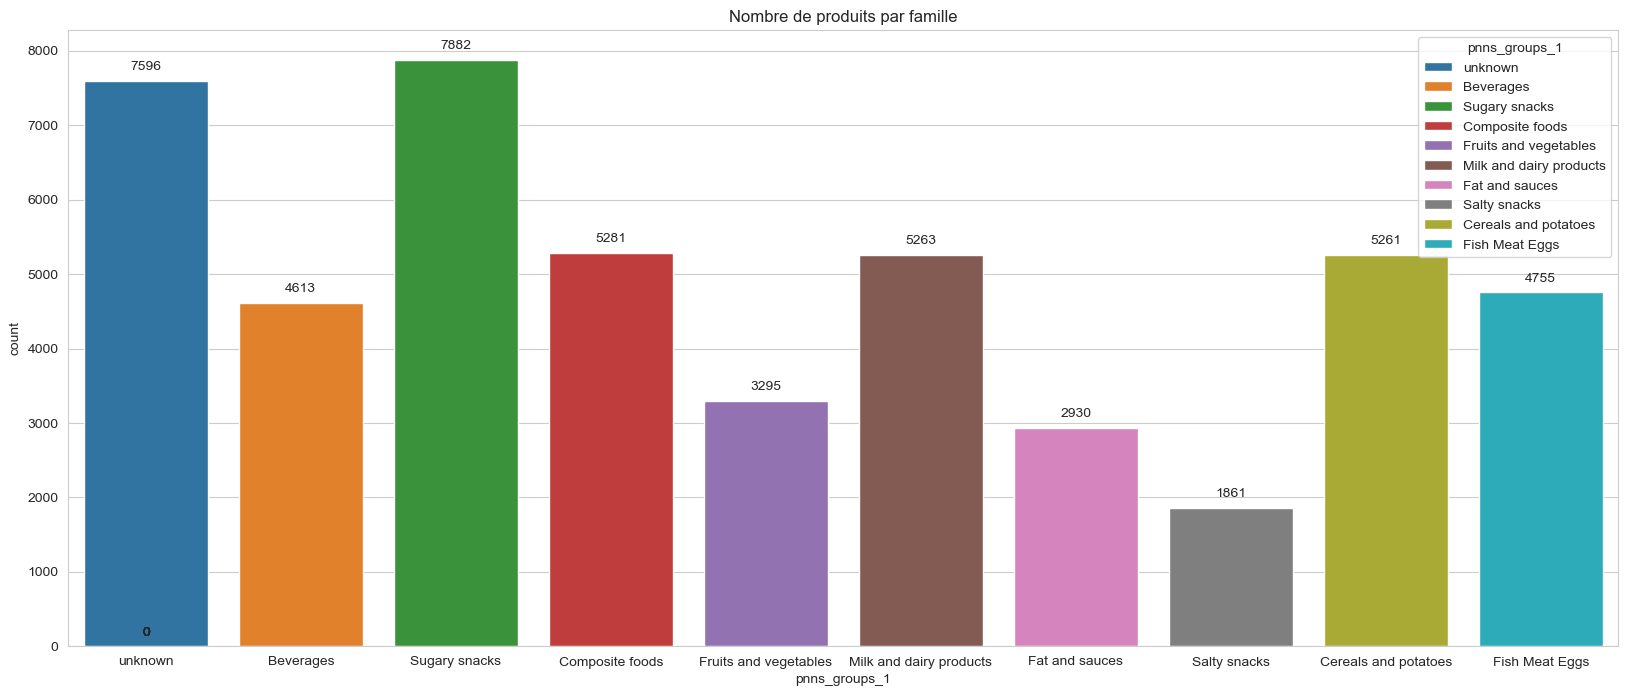

In [35]:
# Visualisation graphique
plt.figure(figsize=(20,8))
ax = sns.countplot(x="pnns_groups_1", data=data, hue ="pnns_groups_1")
plt.title("Nombre de produits par famille")

for p in ax.patches:
    ax.annotate(format(p.get_height(), ".0f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [36]:
# Harmonisation des observations du pnns_groups_2

data['pnns_groups_2'].unique()

array(['unknown', nan, 'Sweetened beverages', 'Biscuits and cakes',
       'One-dish meals', 'Soups', 'Non-sugared beverages', 'Cheese',
       'Sweets', 'Sandwich', 'Dressings and sauces', 'Appetizers',
       'Dried fruits', 'Nuts', 'Breakfast cereals',
       'Pizza pies and quiche', 'Fruits', 'Fruit juices', 'Cereals',
       'Vegetables', 'Bread', 'Chocolate products', 'Processed meat',
       'Legumes', 'vegetables', 'Ice cream', 'Fish and seafood',
       'pastries', 'Milk and yogurt', 'Dairy desserts', 'Meat', 'Fats',
       'Artificially sweetened beverages', 'Fruit nectars', 'Potatoes',
       'Alcoholic beverages', 'Salty and fatty products', 'Tripe dishes',
       'Eggs', 'fruits', 'cereals'], dtype=object)

In [37]:
data.loc[data['pnns_groups_2']=='vegetables','pnns_groups_2']='Vegetables'
data.loc[data['pnns_groups_2']=='fruits','pnns_groups_2']='Fruits'
data.loc[data['pnns_groups_2']=='legumes','pnns_groups_2']='Legumes'

In [38]:
data['pnns_groups_2'].unique()

array(['unknown', nan, 'Sweetened beverages', 'Biscuits and cakes',
       'One-dish meals', 'Soups', 'Non-sugared beverages', 'Cheese',
       'Sweets', 'Sandwich', 'Dressings and sauces', 'Appetizers',
       'Dried fruits', 'Nuts', 'Breakfast cereals',
       'Pizza pies and quiche', 'Fruits', 'Fruit juices', 'Cereals',
       'Vegetables', 'Bread', 'Chocolate products', 'Processed meat',
       'Legumes', 'Ice cream', 'Fish and seafood', 'pastries',
       'Milk and yogurt', 'Dairy desserts', 'Meat', 'Fats',
       'Artificially sweetened beverages', 'Fruit nectars', 'Potatoes',
       'Alcoholic beverages', 'Salty and fatty products', 'Tripe dishes',
       'Eggs', 'cereals'], dtype=object)

# Recherche et traitement des valeurs aberrantes

## Analyse des variables numériques

In [39]:
data.describe()

energy_100g      fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  6.291700e+04  45701.000000        62359.000000        45648.000000   
mean   1.176158e+03     13.276054            5.423381           27.778450   
std    1.300515e+04     16.888191            8.531668           27.319808   
min    0.000000e+00      0.000000            0.000000            0.000000   
25%    4.300000e+02      1.300000            0.300000            4.100000   
50%    1.038000e+03      6.800000            2.000000           14.700000   
75%    1.653000e+03     21.000000            7.400000           53.000000   
max    3.251373e+06    380.000000          210.000000          190.000000   

        sugars_100g    fiber_100g  proteins_100g     salt_100g   sodium_100g  \
count  62416.000000  45716.000000   62785.000000  62468.000000  62467.000000   
mean      13.378901      2.559466       7.737782      1.156485      0.455315   
std       19.026129      4.635102       7.871803      4.268056      1.680293   
min       -0.100000      0.000000       0.000000      0.000000      0.000000   
25%        1.000000      0.000000       1.800000      0.080000      0.031496   
50%        4.000000      1.380000       6.000000      0.560000      0.220472   
75%       17.600000      3.200000      10.800000      1.244600      0.490000   
max      104.000000    178.000000     100.000000    211.000000     83.000000   

       fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
count                  2827.000000             61334.000000  
mean                     30.524609                 8.694851  
std                      32.178404                 9.046375  
min                       0.000000               -15.000000  
25%                       0.000000                 1.000000  
50%                      19.900000                 9.000000  
75%                      50.000000                15.000000  
max                     100.000000                40.000000

''' Pour les nutriments dont les valeurs nutritionnelles sont définies pour 100g (hors nutrition-score-fr_100g), ces valeurs ne peuvent qu'être comprises entre 0g et 100g au maximum.

Il s'agit ici des variables saturated-fat_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g et fruits-vegetables-nuts_100g.
Pour ces variables nous décidons pour le traitement des valeurs aberrantes de les remplacer par None, elles feront ensuite l'objet d'une imputation dans la phase d'imputation des valeurs manquantes.

En analysant le descriptif des variables numériques fourni ci-dessus, nous identifions rapidement les variables ayant les valeurs maximales 
supérieures à 100g (saturated-fat_100g, sugars_100g, fiber_100g).

Nous n'identifions pas de valeurs aberrantes dans les observations de la variable nutrition-score-fr_100g compte tenu de sa méthode de calcul, le minimun étant à -15 et la maximum 40.'''

In [40]:
data.loc[data['saturated-fat_100g']>100,'saturated-fat_100g']= None
data.loc[((data['sugars_100g']<0)|(data['sugars_100g']>100)),'sugars_100g']= None
data.loc[data['fiber_100g']>100,'fiber_100g']= None

'''Concernant la variable energy_100g l'analyse est différente. L'unité de mesure donnée pour les observations ici est en KJ/100g.
Nous savons aussi que concernant les aliments, dans 100g d'aliment nous pouvons avoir une valeur énergétique bien supérieure à 100KJ.
Nos recherche sur les valeurs énergiques maximales pour les aliments du commerce montrent que pour 100g d'aliment, nous pouvons avoir une valeur
énergétique au maximum de 480 Kcal soit 480 * 4.184 = 2008.32 KJ
Nous décidons d'identifier toutes les valeurs supérieures à 2008.32, nous les remplaçons par None, elles feront ensuite l'objet d'une imputation dans la phase
d'imputation des valeurs manquantes.'''

In [41]:
data.loc[data["energy_100g"]>2008.32,"energy_100g"]= None

'''Observation de certaines cohérences.
Nous savons que pour un produit donné sa teneur en saturated-fat_100g ne peut être supérieure à sa teneur en fat_100g
De même, la teneur en carbohydrates_100g ne peut pas être inférieure à la teneur en sugars_100g. Pour les incohérences identifiées, nous remplaçons les 
valeurs par None. Elles feront ensuite l'objet d'une imputation.'''

In [42]:
data.loc[data["saturated-fat_100g"]>data["fat_100g"],"saturated-fat_100g"] = None

In [43]:
data.loc[data["carbohydrates_100g"]<data["sugars_100g"],"sugars_100g"] = None

''' Nous ne traitons pas les valeurs maximales aberrantes pour les variables fat_100g, carbohydrates_100g et salt_100g car ce sont des variables que nous
n'allons pas conserver in fine, nous les avons gardé juste pour la cohérence de certaines valeurs comme expliqué ci-dessus.'''

## Recherche statistique des valeurs aberrantes : méthode IQR

'''L'IQR est défini comme la différence entre le troisième quartile (Q3) et le premier quartile (Q1) de la distribution des données. Les bornes inférieure et supérieure de la plage plausible sont définies comme suit :

- Limite inférieure : Q1 - 1,5 x IQR
- Limite supérieure : Q3 + 1,5 x IQR
Les observations en dehors de ces bornes sont considérées comme des valeurs aberrantes.
Nous ne pouvons cependant pas considérer tous les produits comme étant de la même catégorie car ils n'ont pas les mêmes compositions de valeur
nnutritionnelle selon la catégorie. Nous allons donc mettre en oeuvre le calcul des IQR en faisant des boxplots par catégorie de produit.'''

'''Nous allons utiliser les catégories de produits définies dans la variable pnns_groups_1 pour faire une analyse par catégorie'''

In [44]:
# Liste des catégories définies dans pnns_groups_1 (hors nan et unknown)

Liste =['Cereals and potatoes','Sugary snacks','Beverages','Fish Meat Eggs','Composite foods',
        'Fruits and vegetables','Milk and dairy products','Salty snacks','Fat and sauces']

----------------------------------------------------------------------------------------------------
Cereals and potatoes


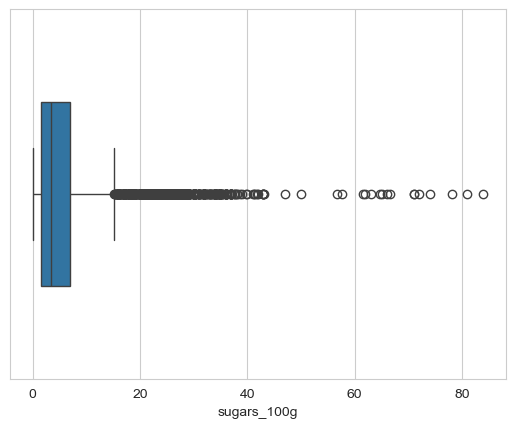

----------------------------------------------------------------------------------------------------
Sugary snacks


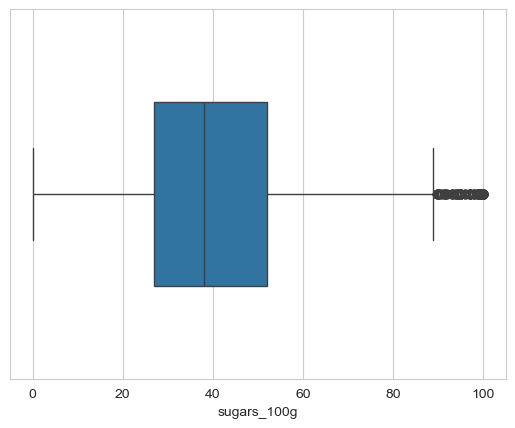

----------------------------------------------------------------------------------------------------
Beverages


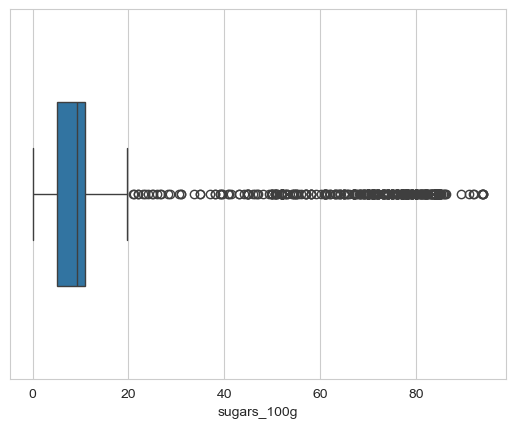

----------------------------------------------------------------------------------------------------
Fish Meat Eggs


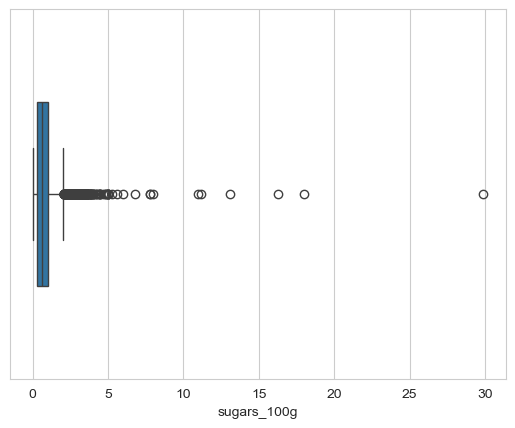

----------------------------------------------------------------------------------------------------
Composite foods


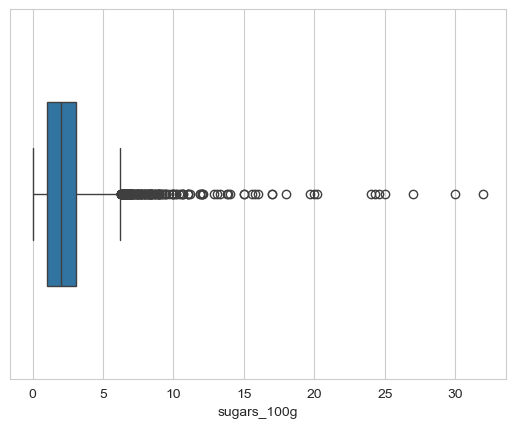

----------------------------------------------------------------------------------------------------
Fruits and vegetables


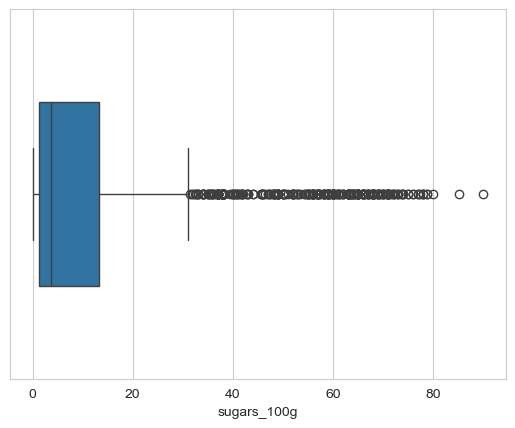

----------------------------------------------------------------------------------------------------
Milk and dairy products


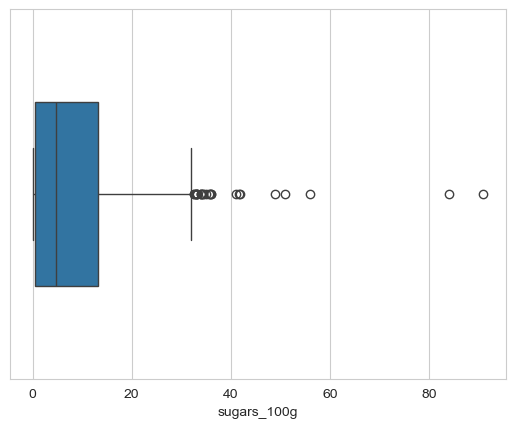

----------------------------------------------------------------------------------------------------
Salty snacks


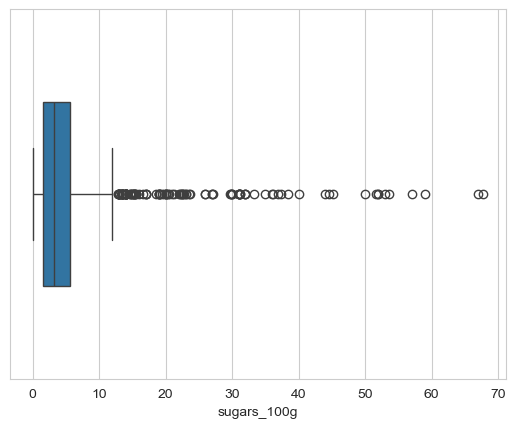

----------------------------------------------------------------------------------------------------
Fat and sauces


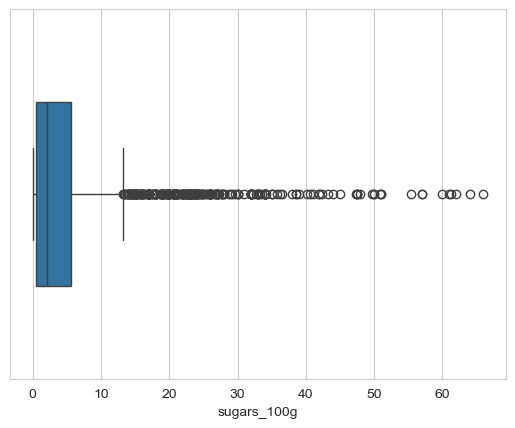

In [45]:
for var in Liste:
    data1 = data[data['pnns_groups_1']==var]
    print("-"*100)
    print(var)
    sns.boxplot(data = data1, x='sugars_100g',width=.5)
    plt.show()

# Calcul des quartiles et IQR par famille de produit

In [46]:
for cat in Liste :
    data2 = data.loc[data['pnns_groups_1']== cat,'sugars_100g']
    q1 = data2.quantile(0.25)
    q3 = data2.quantile(0.75)
    iqr = q3 - q1
    upper_whisker = round((q3 + 1.5*iqr),1)
    lower_whisker = round((q1 - 1.5*iqr),1)
    print("-"*100)
    print(cat)
    print('q1:',q1,'q3:',q3,'iqr:',iqr,'lower_whisker:',lower_whisker,'upper_whisker:',upper_whisker)

----------------------------------------------------------------------------------------------------
Cereals and potatoes
q1: 1.6 q3: 7.0 iqr: 5.4 lower_whisker: -6.5 upper_whisker: 15.1
----------------------------------------------------------------------------------------------------
Sugary snacks
q1: 27.0 q3: 52.0 iqr: 25.0 lower_whisker: -10.5 upper_whisker: 89.5
----------------------------------------------------------------------------------------------------
Beverages
q1: 5.1 q3: 11.0 iqr: 5.9 lower_whisker: -3.8 upper_whisker: 19.8
----------------------------------------------------------------------------------------------------
Fish Meat Eggs
q1: 0.3 q3: 1.0 iqr: 0.7 lower_whisker: -0.7 upper_whisker: 2.0
----------------------------------------------------------------------------------------------------
Composite foods
q1: 1.0 q3: 3.11 iqr: 2.11 lower_whisker: -2.2 upper_whisker: 6.3
-----------------------------------------------------------------------------------------

In [47]:
# Les outliers statistiques sont-ils de véritables outliers ou alors juste de valeurs atypiques?
# Observons plus précisément la famille 'Sugary snacks'

data3 = data.loc[data['pnns_groups_1']=='Sugary snacks',['product_name','generic_name','categories','sugars_100g']]
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]
outliers = detect_outliers_iqr(data3, 'sugars_100g')
print("Variable: Sugars_100g")
print("Famille: Sugary snacks")
print("Outliers détectés:")
display(outliers)

Variable: Sugars_100g
Famille: Sugary snacks
Outliers détectés:


product_name               generic_name  \
99449                              Rainbow Nerds                        NaN   
99452   Wonka Nerds Starwberry And Grape Theatre                        NaN   
178777              Bonbons fruités cœur liquide                        NaN   
179003                           sucre cassonade                 pure canne   
179053                        Sucres en morceaux                        NaN   
...                                          ...                        ...   
318369                                       PEZ  Bonbons au goût de fruits   
318371                            Justice League   Bonbons au goût de fruit   
318372                         Pez Despicable Me  Bonbons au gout de fruits   
318373                                    Trolls                        NaN   
318374                                     Rio 2   Bonbons au goût de fruit   

                                   categories  sugars_100g  
99449       Snacks sucrés,Confiseries,Bonbons         93.3  
99452                                 Bonbons         98.0  
178777                                Bonbons         92.9  
179003                            Sucres roux         99.0  
179053  Édulcorants,Sucres,Sucres en morceaux        100.0  
...                                       ...          ...  
318369                                Bonbons         95.0  
318371      Snacks sucrés,Confiseries,Bonbons         95.0  
318372      Snacks sucrés,Confiseries,Bonbons         95.0  
318373                                Bonbons         95.0  
318374                                Bonbons         95.0  

[187 rows x 4 columns]

'''Nous observons que les teneurs identifiées statistiquement comme aberrantes par la méthode IQR ne sont en fait que des valeurs atypiques.
En effet une teneur en sucre 100g pour 100g de sucres en morceaux est tout à fait normal (Cf. produit 179053) ou une teneur en sucre supérieure
à 90g pour des bonbons est tout à fait normale.
Par la méthode IQR, nous n'allons pas considérer les valeurs identifiées comme étant des valeurs aberrantes'''


## Analyse des variables catégorielles

In [48]:
data.describe(include=['object'])

code                                                url  \
count           62959                                              62959   
unique          62959                                              62959   
top     0000000036252  http://world-fr.openfoodfacts.org/produit/0000...   
freq                1                                                  1   

         created_t      created_datetime last_modified_t  \
count        62959                 62958           62959   
unique       62800                 62799           61323   
top     1473946144  2016-09-15T13:29:04Z      1492710585   
freq             5                     5               8   

       last_modified_datetime                product_name  \
count                   62959                       62595   
unique                  61323                       52336   
top      2017-04-20T17:49:45Z  Huile d'olive vierge extra   
freq                        8                          43   

                                             generic_name quantity  \
count                                               30741    47079   
unique                                              22647     6964   
top     Pâtes alimentaires au blé dur de qualité supér...    500 g   
freq                                                  181     2318   

                                        categories countries_fr  \
count                                        45945        62959   
unique                                       20143          244   
top     Snacks sucrés,Biscuits et gâteaux,Biscuits       France   
freq                                           262        59905   

        pnns_groups_1 pnns_groups_2 nutrition_grade_fr  
count           48737         48833              61334  
unique             10            38                  5  
top     Sugary snacks       unknown                  d  
freq             7882          7596              16991

'''Nous n'observons aucune anomalie quant à la nature et le type des variables catégorielles'''

# Traitement des valeurs manquantes

In [49]:
## Affectation de la date de dernière modification en cas de date de création manquante

data.loc[data['created_datetime'].isna(),'created_datetime'] = data['last_modified_datetime']

In [50]:
## Suppression de l'ensemble des lignes pour lesquelles le product_name n'est pas renseigné

data = data.dropna(subset=['product_name'])

'''Attribution du product_name au generic_name en cas de valeur manquante dans le generic_name
Concernant la variable 'generic_name', nous choisissons de lui attribuer le product_name par défaut si elle est manquante.'''

In [51]:
data.loc[((~data['product_name'].isna()) & (data['generic_name'].isna())),'generic_name'] = data['product_name']

In [52]:
## Attribution de la valeur 'unknown' à tous les produits dont la variable 'quantity' est manquante.

data.loc[data['quantity'].isna(),'quantity']='unknown'

In [53]:
## Concernant la variable fiber_100g

data.loc[data['fiber_100g'].isna(),'fiber_100g'] = 0

'''Les fibres sont des nutriments sains pour la santé et plutôt prisés par le consommateur en France.
Tout producteur ou distributeur a tout intérêt à le mentionner sur les emballages.
Dans ces circonstances,nous considérons que leur abscence signifie que le produit en question n'en contient pas.
Nous remplaçons dont les valeurs manquantes par 0.'''

## Concernant la variable fruits-vegetables-nuts_100g

'''Dans la même logique que les fibers, ce sont des nutriments sains pour la santé, conseillés et recherchés par le consommateur.
Nous allons procéder en 2 étapes :
- En cas de valeur manquante pour la famille 'Fruits and vegetables', nous remplaçons la valeur manquante par la moyenne de la catégorie car nous estimons que pour
cette famille en particulier, l'absence de cette valeur est anormale.
- Pour les autres familles, en cas de valeur manquante, nous considérons que le produit n'en a pas et imputons à 0.'''

In [54]:
data_FruitVegetables_mean = data.loc[data['pnns_groups_1']=='Fruits and vegetables','fruits-vegetables-nuts_100g']

mean_FruitVegetables = data_FruitVegetables_mean.mean()

data.loc[(data['pnns_groups_1']=='Fruits and vegetables') & (data['fruits-vegetables-nuts_100g'].isna()),'fruits-vegetables-nuts_100g']= mean_FruitVegetables

data.loc[(data['pnns_groups_1']!='Fruits and vegetables') & (data['fruits-vegetables-nuts_100g'].isna()),'fruits-vegetables-nuts_100g']= 0


## Concernant la variable sodium_100g

'''Les connaissances métier nous montrent que la valeur de la teneur en sodium est égale à celle de teneur en sel/2.5
Nous traitons les valeurs manquantes de la variable sodium_100g en 3 étapes :
- Quand la teneur en salt_100g est = 0, nous affectons également 0 à la teneur en sodium_100g,
- Quand la teneur en salt_100g est mentionnée et que celle en sodium_100g est manquante, nous imputons salt_100g/2.5 à sodium_100g,
- Ensuite pour toutes les autres valeurs manquantes résiduelles de la variable sodium_100g, nous appliques la méthode de l'IterativeImputer pour les imputer.'''

In [55]:
data.loc[((data['salt_100g']== 0) & (data['sodium_100g'].isna())),'sodium_100g']= 0

data.loc[((~data['salt_100g'].isna()) & (data['sodium_100g'].isna())),'sodium_100g'] = data['salt_100g']/2.5

In [56]:
data.loc[((data['salt_100g']== 0) & (data['sodium_100g']!=0)),['salt_100g','sodium_100g']]

Empty DataFrame
Columns: [salt_100g, sodium_100g]
Index: []

## Traitement du pnns_groups_1
'''Nous avons réalisé une analyse de correspondance entre les catégories de produits en pnns_groups_1 et les catégories en pnns_groups_2.
Ces correpondances nous permettent d'identifier pour les produits dont l'observation pnns_groups_2 est connue et ceux pnns_groups_1 est non connu afin 
de compléter les valeurs manquantes'''

In [57]:
data.loc[(data['pnns_groups_1'].isna() & ~data['pnns_groups_2'].isna()),:]

code                                                url  \
175882  2000000021470  http://world-fr.openfoodfacts.org/produit/2000...   
177291       20025007  http://world-fr.openfoodfacts.org/produit/2002...   
178134       20133177  http://world-fr.openfoodfacts.org/produit/2013...   
179600       20387693  http://world-fr.openfoodfacts.org/produit/2038...   
184557       26017266  http://world-fr.openfoodfacts.org/produit/2601...   
...               ...                                                ...   
278302  5410228217312  http://world-fr.openfoodfacts.org/produit/5410...   
278323  5410228228455  http://world-fr.openfoodfacts.org/produit/5410...   
280984  5601144816011  http://world-fr.openfoodfacts.org/produit/5601...   
307241  8410414000909  http://world-fr.openfoodfacts.org/produit/8410...   
311590  8480017044075  http://world-fr.openfoodfacts.org/produit/8480...   

         created_t      created_datetime last_modified_t  \
175882  1442154646  2015-09-13T14:30:46Z      1452597672   
177291  1467549645  2016-07-03T12:40:45Z      1467554170   
178134  1433600457  2015-06-06T14:20:57Z      1489003651   
179600  1422647746  2015-01-30T19:55:46Z      1453557029   
184557  1445596039  2015-10-23T10:27:19Z      1445596966   
...            ...                   ...             ...   
278302  1436194240  2015-07-06T14:50:40Z      1488484743   
278323  1485602443  2017-01-28T11:20:43Z      1485607135   
280984  1372437239  2013-06-28T16:33:59Z      1413284418   
307241  1402853600  2014-06-15T17:33:20Z      1485888451   
311590  1372621905  2013-06-30T19:51:45Z      1437560459   

       last_modified_datetime                       product_name  \
175882   2016-01-12T11:21:12Z                       Bière blonde   
177291   2016-07-03T13:56:10Z                            Panaché   
178134   2017-03-08T20:07:31Z               St emilion grand cru   
179600   2016-01-23T13:50:29Z           Tripes à la mode de Caen   
184557   2015-10-23T10:42:46Z           Tripes à la mode de Caen   
...                       ...                                ...   
278302   2017-03-02T19:59:03Z                   Leffe des Vignes   
278323   2017-01-28T12:38:55Z  Cubanisto beer with mojito flavor   
280984   2014-10-14T11:00:18Z             Spéciale Réserve Porto   
307241   2017-01-31T18:47:31Z              Vodka 100 cl Eristoff   
311590   2015-07-22T10:20:59Z          Tripes à la mode de Caen    

                                             generic_name  \
175882                                       Bière blonde   
177291                                            Panaché   
178134                               St emilion grand cru   
179600                           Tripes à la mode de Caen   
184557                           Tripes à la mode de Caen   
...                                                   ...   
278302                                   Leffe des Vignes   
278323                        Cubanisto bière mojito 5,9°   
280984                                        Porto rouge   
307241                                             Vodka    
311590  Tripes de bœuf cuisinées accompagnées de carot...   

                       quantity  \
175882                    33 cl   
177291   2,5 L - ( 10 × 25 cl )   
178134                     75cl   
179600                    500 g   
184557                 0,500 kg   
...                         ...   
278302                6 x 25 cl   
278323                3 x 33 cL   
280984                    75 cl   
307241                   100 cl   
311590                    400 g   

                                               categories  ... sugars_100g  \
175882  Boissons,Boissons alcoolisées,Bières,Bières bl...  ...       0.200   
177291             Boissons,Boissons sans alcool,Panachés  ...       6.000   
178134         French red wine,fr:Saint-Emilion grand cru  ...       1.000   
179600  Poissons et viandes et oeufs,Abats,Produits tr...  ...       0.100   
184557  Frais,Plats pr

In [58]:
liste1 = ['Breakfast cereals','Cereals','Potatoes','Cereals and potatoes'] #Cereals and potateos

liste2 = ['Sweets','pastries','Biscuits and cakes','Chocolate products'] #Sugary snacks

liste3 = ['Non-sugared beverages','Sweetened beverages','Alcoholic beverages','Fruit juices',
          'Artificially sweetened beverages','Fruit nectars'] #Beverages

liste4 = ['Meat','Processed meat','Fish and seafood','Eggs'] #Fish Meat Eggs

liste5 = ['Pizza pies and quiche','Sandwich','Tripe dishes','One-dish meals','Soups','Bread'] #Composite foods

liste6 = ['Fruits','Vegetables','Dried fruits','Legumes','Nuts'] #Fruits and vegetables

liste7 = ['Milk and yogurt','Cheese','Dairy desserts','Ice cream'] #Milk and dairy products

liste8 = ['Salty and fatty products','Appetizers'] #Salty snacks

liste9 = ['Dressings and sauces','Fats'] #Fat and sauces

In [59]:
data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste1)),'pnns_groups_1']='Cereals and potateos'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste2)),'pnns_groups_1']='Sugary snacks'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste3)),'pnns_groups_1']='Beverages'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste4)),'pnns_groups_1']='Fish Meat Eggs'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste5)),'pnns_groups_1']='Composite foods'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste6)),'pnns_groups_1']='Fruits and vegetables'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste7)),'pnns_groups_1']='Milk and dairy products'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste8)),'pnns_groups_1']='Salty snacks'

data.loc[(data['pnns_groups_1'].isna() & data['pnns_groups_2'].isin(liste9)),'pnns_groups_1']='Fat and sauces'

In [60]:
data.loc[(data['pnns_groups_1'].isna() & ~data['pnns_groups_2'].isna()),:]

Empty DataFrame
Columns: [code, url, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, categories, countries_fr, energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, fruits-vegetables-nuts_100g, pnns_groups_1, pnns_groups_2, nutrition-score-fr_100g, nutrition_grade_fr]
Index: []

[0 rows x 25 columns]

In [61]:
data.loc[(data['pnns_groups_1'].isna() & ~data['categories'].isna()),:]

Empty DataFrame
Columns: [code, url, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, categories, countries_fr, energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, fruits-vegetables-nuts_100g, pnns_groups_1, pnns_groups_2, nutrition-score-fr_100g, nutrition_grade_fr]
Index: []

[0 rows x 25 columns]

In [62]:
data.loc[(data['pnns_groups_2'].isna() & data['pnns_groups_1'].isna() & ~data['categories'].isna()),:]

Empty DataFrame
Columns: [code, url, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, categories, countries_fr, energy_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, fiber_100g, proteins_100g, salt_100g, sodium_100g, fruits-vegetables-nuts_100g, pnns_groups_1, pnns_groups_2, nutrition-score-fr_100g, nutrition_grade_fr]
Index: []

[0 rows x 25 columns]

In [63]:
data.loc[(data['pnns_groups_2'].isna() & data['pnns_groups_1'].isna() & data['categories'].isna()),:]

code                                                url  \
190     0000010187319  http://world-fr.openfoodfacts.org/produit/0000...   
191     0000010207260  http://world-fr.openfoodfacts.org/produit/0000...   
234     0000069161025  http://world-fr.openfoodfacts.org/produit/0000...   
307     0000606009841  http://world-fr.openfoodfacts.org/produit/0000...   
457          00011747  http://world-fr.openfoodfacts.org/produit/0001...   
...               ...                                                ...   
320690       96087770  http://world-fr.openfoodfacts.org/produit/9608...   
320698       96103890  http://world-fr.openfoodfacts.org/produit/9610...   
320740  9782211109758  http://world-fr.openfoodfacts.org/produit/9782...   
320741  9782401029101  http://world-fr.openfoodfacts.org/produit/9782...   
320757  9900000000233  http://world-fr.openfoodfacts.org/produit/9900...   

         created_t      created_datetime last_modified_t  \
190     1487325954  2017-02-17T10:05:54Z      1487325954   
191     1490203031  2017-03-22T17:17:11Z      1490203757   
234     1490212776  2017-03-22T19:59:36Z      1490212776   
307     1485947637  2017-02-01T11:13:57Z      1485947637   
457     1424634361  2015-02-22T19:46:01Z      1491142413   
...            ...                   ...             ...   
320690  1492527854  2017-04-18T15:04:14Z      1492527854   
320698  1481118706  2016-12-07T13:51:46Z      1487351408   
320740  1489003558  2017-03-08T20:05:58Z      1489003558   
320741  1491508021  2017-04-06T19:47:01Z      1491508021   
320757  1491079938  2017-04-01T20:52:18Z      1491079939   

       last_modified_datetime                                   product_name  \
190      2017-02-17T10:05:54Z                                 Mini Confettis   
191      2017-03-22T17:29:17Z                     Praliné Amande Et Noisette   
234      2017-03-22T19:59:36Z                      Tarte Poireaux Et Lardons   
307      2017-02-01T11:13:57Z                            Beignets framboises   
457      2017-04-02T14:13:33Z         Triple Belgian Chocolaté Chunk Cookies   
...                       ...                                            ...   
320690   2017-04-18T15:04:14Z  Peanut & Popcorn With Dark Chocolate 12 x 45G   
320698   2017-02-17T17:10:08Z                     Eat Natural Protein Packed   
320740   2017-03-08T20:05:58Z                     Verrine Cheescake Myrtille   
320741   2017-04-06T19:47:01Z                                   Fiche Brevet   
320757   2017-04-01T20:52:19Z                                        Amandes   

                                         generic_name quantity categories  \
190                                    Mini Confettis  unknown        NaN   
191                        Praliné Amande Et Noisette  unknown        NaN   
234                         Tarte Poireaux Et Lardons  unknown        NaN   
307                               Beignets framboises  unknown        NaN   
457            Triple Belgian Chocolaté Chunk Cookies  unknown        NaN   
...                                               ...      ...        ...   
320690  Peanut & Popcorn With Dark Chocolate 12 x 45G  unknown        NaN   
320698                     Eat Natural Protein Packed  unknown        NaN   
320740                     Verrine Cheescake Myrtille  unknown        NaN   
320741                                   Fiche Brevet  unknown        NaN   
320757                                        Amandes  unknown        NaN   

        ... sugars_100g  fiber_100g  proteins_100g  salt_100g  sodium_100g  \
190     ...       87.70         0.9           0.60      0.010     0.003937   
191     ...       50.30         3.9           9.50      0.003     0.001181   
234     ...        1.00         1.4           7.50      0.800     0.314961   
307     ...       12.70         0.0           5.80      0.700     0.275591   
457     ...       34.40         2.9           5.60      0.850     0.334646   
...     ...         ...      

'''Nous constatons le reste des valeurs manquantes de la variables 'pnns_groups_1' présentent également des valeurs manquantes en 'pnns_groups_2' et
en 'categories'.Nous décidons de ne pas supprimer les produits correspondant mais de les mentionner comme 'unknown' en pnns_groups_1.'''

In [64]:
data.loc[data['pnns_groups_1'].isna(),'pnns_groups_1']='unknown'

## Imputation des valeurs manquantes des variables energy_100g, sugars_100g, saturated-fat_100g, proteins_100g et sodium_100g.

'''Pour ces imputations, nous choisissons de les imputer par la moyenne de chaque famille (au sens pnns_groups_1) de produit.'''


In [65]:
### Nous retenons pour notre dataset que les variables utiles pour la solution que nous proposons

data = data.drop(columns=['categories','fat_100g','salt_100g','carbohydrates_100g','pnns_groups_2'],axis=1)

In [66]:
### Pour la variable energy_100g

Liste =['Cereals and potatoes','Sugary snacks','Beverages','Fish Meat Eggs','Composite foods',
        'Fruits and vegetables','Milk and dairy products','Salty snacks','Fat and sauces']
for cat in Liste:
    data_energy_mean = data.loc[data['pnns_groups_1']==cat,'energy_100g']
    mean_energy = data_energy_mean.mean()
    data.loc[((data['pnns_groups_1']==cat) & (data['energy_100g'].isna())),'energy_100g'] = mean_energy

In [67]:
### Pour la variable sugars_100g

for cat in Liste:
    data_sugars_mean = data.loc[data['pnns_groups_1']==cat,'sugars_100g']
    mean_sugars = data_sugars_mean.mean()
    data.loc[((data['pnns_groups_1']==cat) & (data['sugars_100g'].isna())),'sugars_100g'] = mean_sugars

In [68]:
### Pour la variable saturated-fat_100g

for cat in Liste:
    data_saturatedfat_mean = data.loc[data['pnns_groups_1']==cat,'saturated-fat_100g']
    mean_saturatedfat = data_saturatedfat_mean.mean()
    data.loc[((data['pnns_groups_1']==cat) & (data['saturated-fat_100g'].isna())),'saturated-fat_100g'] = mean_saturatedfat

In [69]:
### Pour la variable proteins_100g

for cat in Liste:
    data_proteins_mean = data.loc[data['pnns_groups_1']==cat,'proteins_100g']
    mean_proteins = data_proteins_mean.mean()
    data.loc[((data['pnns_groups_1']==cat) & (data['proteins_100g'].isna())),'proteins_100g'] = mean_proteins

In [70]:
### Pour la variable sodium_100g

for cat in Liste:
    data_sodium_mean = data.loc[data['pnns_groups_1']==cat,'sodium_100g']
    mean_sodium = data_sodium_mean.mean()
    data.loc[((data['pnns_groups_1']==cat) & (data['sodium_100g'].isna())),'sodium_100g'] = mean_sodium

In [71]:
data.shape

(62595, 20)

In [72]:
data.loc[(((data['energy_100g'].isna()) | (data['saturated-fat_100g'].isna()) | (data['sugars_100g'].isna()) | (data['proteins_100g'].isna()) |
          (data['sodium_100g'].isna())) & (data['pnns_groups_1']=='unknown')), ['energy_100g','saturated-fat_100g','sugars_100g',
                                                                                'proteins_100g','sodium_100g','pnns_groups_1']]

energy_100g  saturated-fat_100g  sugars_100g  proteins_100g  \
138          1481.0                 NaN          NaN           6.25   
191             NaN                2.90        50.30           9.50   
457             NaN               17.00        34.40           5.60   
509             NaN                7.60        29.40           6.00   
597             NaN                1.90         1.80           6.80   
...             ...                 ...          ...            ...   
320532       1806.0                9.30         8.90           9.90   
320545          NaN               10.00        10.00          15.72   
320561          NaN                4.70         4.00           9.70   
320689          NaN                6.10        17.90          19.00   
320757          NaN                3.73         3.89          21.22   

        sodium_100g pnns_groups_1  
138             NaN       unknown  
191        0.001181       unknown  
457        0.334646       unknown  
509        0.145669       unknown  
597        0.314961       unknown  
...             ...           ...  
320532          NaN       unknown  
320545     0.787402       unknown  
320561     0.000000       unknown  
320689     0.118110       unknown  
320757     0.039370       unknown  

[3346 rows x 6 columns]

'''Nous identifions ci-dessus la liste des produits pour lesquels nous n'avons pas pu les attribuer à une famille car le pnns_groups_1 est inconnu et par conséquence 
le pnns_groups_2 et la categorie inconnus également. A cette étape, ces produits représentent 3346/62595 soit 5.34%. Dans l'impossibilité d'avoir l'ensemble des données
nécessaires pour les analyser, nous décidons de les supprimer.'''

In [73]:
data = data.dropna(subset=['energy_100g','saturated-fat_100g','sugars_100g','proteins_100g','sodium_100g'])

'''Observons l'état des valeurs manquantes pour chaque variables. Les seules variables restant à traiter sont nutrition-score-fr_100g et nutrition_grade_fr.
Pour la variable "nutrition-score-fr_100g", nous allons l'imputer via KNN Imputer. 
Nous utiliserons ensuite les nutrition-score imputés et système de détermination du nutrition grade pour imputer les valeurs manquantes de la variable "nutrition_grade_fr".

In [74]:
# Tableau des valeurs manquantes par variables

missing_values = data.isnull().sum()
missing_percent = round((missing_values/len(data))*100,3)
missing_table = pd.DataFrame({"Missing Values":missing_values,"Percentage":missing_percent})
print(missing_table)

                             Missing Values  Percentage
code                                      0       0.000
url                                       0       0.000
created_t                                 0       0.000
created_datetime                          0       0.000
last_modified_t                           0       0.000
last_modified_datetime                    0       0.000
product_name                              0       0.000
generic_name                              0       0.000
quantity                                  0       0.000
countries_fr                              0       0.000
energy_100g                               0       0.000
saturated-fat_100g                        0       0.000
sugars_100g                               0       0.000
fiber_100g                                0       0.000
proteins_100g                             0       0.000
sodium_100g                               0       0.000
fruits-vegetables-nuts_100g               0     

In [75]:
# Réinitialisation de l'index des données après les différents traitements précédents

data = data.reset_index(drop=True)

In [76]:
# Imputation des valeurs manquantes nutrition-score-fr_100g via KNN

# Nous séparons les données pour ne conserver que les variables numériquees comprenant la variable à imputer

liste_a = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g',
                             'sodium_100g','fruits-vegetables-nuts_100g','nutrition-score-fr_100g']

X = data.loc[:,['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g',
                             'sodium_100g','fruits-vegetables-nuts_100g','nutrition-score-fr_100g']]

In [77]:
# Nous créons knn et choisissons d'imputer en fonction des 20 plus proches voisins

knn = KNNImputer(n_neighbors =20, weights='distance')

In [78]:
# Nous appliquons la méthode définie, afin de réaliser les imputations

X_trf = knn.fit_transform(X)

In [79]:
# Nous créons un dataframe qui recevra l'ensemble des valeurs imputées

X_trf = pd.DataFrame(data=X_trf,columns= liste_a)

In [80]:
X_trf

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  \
0      1883.000000                12.5         57.5         2.5   
1      1753.000000                 0.8         87.7         0.9   
2       177.000000                 0.0         10.4         0.0   
3      1079.000000                11.0          1.0         1.4   
4       177.000000                 0.0         10.4         0.0   
...            ...                 ...          ...         ...   
59244  1583.546169                 3.4          1.8         5.6   
59245  1084.000000                12.0         10.5         0.0   
59246     4.000000                 1.0          1.0        10.0   
59247  1643.000000                 0.6          2.6         5.9   
59248    21.000000                 0.2          0.5         0.2   

       proteins_100g  sodium_100g  fruits-vegetables-nuts_100g  \
0                2.5     0.038000                          0.0   
1                0.6     0.003937                          0.0   
2                0.0     0.010000                          0.0   
3                7.5     0.314961                          0.0   
4                0.0     0.039370                          0.0   
...              ...          ...                          ...   
59244            7.8     0.531496                          0.0   
59245            8.7     0.114173                          0.0   
59246           10.0     3.937008                          0.0   
59247           13.0     0.267717                          0.0   
59248            0.5     0.010000                          0.0   

       nutrition-score-fr_100g  
0                         22.0  
1                         14.0  
2                         13.0  
3                         15.0  
4                         13.0  
...                        ...  
59244                      9.0  
59245                     16.0  
59246                      0.0  
59247                     -4.0  
59248                      2.0  

[59249 rows x 8 columns]

In [81]:
# Nous récupérons les valeurs y compris les valeurs imputées pour les intégrer à notre dataframe initial 

data['nutrition-score-fr_100g'] = round(X_trf['nutrition-score-fr_100g'],0)

## Imputation des valeurs manquantes de la variable 'nutrition_grade_fr

'''Nous utilisons pour cela la système d'attribution du nutrition grade quand la nutrition score est connu soit :
- nutrition_grade = 'a' si nutrition-score >=-15 et <=-1
- nutrition_grade = 'b' si nutrition-score >=0 et <=2
- nutrition_grade = 'c' si nutrition-score >=3 et <=10
- nutrition_grade = 'd' si nutrition-score >=11 et <=18
- nutrition_grade = 'e' si nutrition-score >=19 et <=40 '''

In [82]:
# Application du système d'attribution à l'ensemble des valeurs manquantes du nutrition_grade_fr

data.loc[((data['nutrition_grade_fr'].isna()) & (data['nutrition-score-fr_100g']>= -15.0) & (data['nutrition-score-fr_100g']<= -1.0)),'nutrition_grade_fr']='a'

data.loc[((data['nutrition_grade_fr'].isna()) & (data['nutrition-score-fr_100g']>= 0.0) & (data['nutrition-score-fr_100g']<= 2.0)),'nutrition_grade_fr']='b'

data.loc[((data['nutrition_grade_fr'].isna()) & (data['nutrition-score-fr_100g']>= 3.0) & (data['nutrition-score-fr_100g']<= 10.0)),'nutrition_grade_fr']='c'

data.loc[((data['nutrition_grade_fr'].isna()) & (data['nutrition-score-fr_100g']>= 11.0) & (data['nutrition-score-fr_100g']<= 18.0)),'nutrition_grade_fr']='d'

data.loc[((data['nutrition_grade_fr'].isna()) & (data['nutrition-score-fr_100g']>= 19.0) & (data['nutrition-score-fr_100g']<= 40.0)),'nutrition_grade_fr']='e'

In [83]:
# Observons s'il existe encore des valeurs manquantes

data.loc[data['nutrition_grade_fr'].isna(),:]

Empty DataFrame
Columns: [code, url, created_t, created_datetime, last_modified_t, last_modified_datetime, product_name, generic_name, quantity, countries_fr, energy_100g, saturated-fat_100g, sugars_100g, fiber_100g, proteins_100g, sodium_100g, fruits-vegetables-nuts_100g, pnns_groups_1, nutrition-score-fr_100g, nutrition_grade_fr]
Index: []

In [84]:
# Transformons les observations nutrition_grade en majuscule pour une meilleure lisibilité sur les graphiques

data['nutrition_grade_fr'] = data['nutrition_grade_fr'].str.upper()

In [85]:
# Le traitement des valeurs manquantes étant achevé, visualisons à nouveau le tableau des valeurs manquantes par variables

missing_values = data.isnull().sum()
missing_percent = round((missing_values/len(data))*100,3)
missing_table = pd.DataFrame({"Missing Values":missing_values,"Percentage":missing_percent})
print(missing_table)

                             Missing Values  Percentage
code                                      0         0.0
url                                       0         0.0
created_t                                 0         0.0
created_datetime                          0         0.0
last_modified_t                           0         0.0
last_modified_datetime                    0         0.0
product_name                              0         0.0
generic_name                              0         0.0
quantity                                  0         0.0
countries_fr                              0         0.0
energy_100g                               0         0.0
saturated-fat_100g                        0         0.0
sugars_100g                               0         0.0
fiber_100g                                0         0.0
proteins_100g                             0         0.0
sodium_100g                               0         0.0
fruits-vegetables-nuts_100g               0     

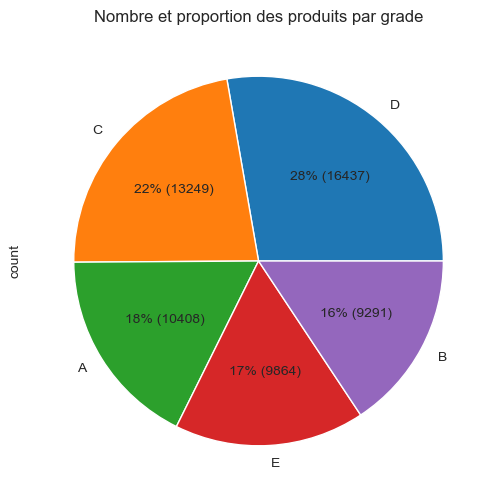

In [86]:
# Visualisons le nombres de produits par catégorie de nutrition grade

# Calculer la proportion de chaque catégorie
prop_data = data["nutrition_grade_fr"].value_counts(normalize=True).reset_index()
prop_data.columns = ["nutrition_grade", "proportion"]

# Graphique en secteurs pour la fréquence de chaque catégorie
plt.figure(figsize=(8,6))
ax = data["nutrition_grade_fr"].value_counts().plot(kind="pie", autopct=lambda x: f'{x:.0f}% ({x/100*len(data):.0f})')

# Ajouter le titre
plt.title("Nombre et proportion des produits par grade")

plt.show()

'''Isolons dans un nouveau dataframe les variables essentielles nécessaires pour les analyses et la mise en place de la solution que nous proposons'''

In [87]:
final_data = data.loc[:,["energy_100g","saturated-fat_100g","sugars_100g","fiber_100g",
                         "proteins_100g","sodium_100g","fruits-vegetables-nuts_100g",
                         "nutrition-score-fr_100g","nutrition_grade_fr"]]
final_data.head(5)

energy_100g  saturated-fat_100g  sugars_100g  fiber_100g  proteins_100g  \
0       1883.0                12.5         57.5         2.5            2.5   
1       1753.0                 0.8         87.7         0.9            0.6   
2        177.0                 0.0         10.4         0.0            0.0   
3       1079.0                11.0          1.0         1.4            7.5   
4        177.0                 0.0         10.4         0.0            0.0   

   sodium_100g  fruits-vegetables-nuts_100g  nutrition-score-fr_100g  \
0     0.038000                          0.0                     22.0   
1     0.003937                          0.0                     14.0   
2     0.010000                          0.0                     13.0   
3     0.314961                          0.0                     15.0   
4     0.039370                          0.0                     13.0   

  nutrition_grade_fr  
0                  E  
1                  D  
2                  E  
3                  D  
4                  E

In [88]:
# Analyses univariées

In [89]:
final_data.shape

(59249, 9)

In [90]:
final_data.describe()

energy_100g  saturated-fat_100g   sugars_100g    fiber_100g  \
count  59249.000000        59249.000000  59249.000000  59249.000000   
mean     940.232966            4.880625     12.864351      1.805627   
std      577.607484            7.701774     18.756447      3.963776   
min        0.000000            0.000000      0.000000      0.000000   
25%      406.000000            0.300000      1.000000      0.000000   
50%      914.000000            1.700000      4.000000      0.100000   
75%     1486.271803            6.500000     15.800000      2.300000   
max     2008.000000          100.000000    100.000000    100.000000   

       proteins_100g   sodium_100g  fruits-vegetables-nuts_100g  \
count   59249.000000  59249.000000                 59249.000000   
mean        7.681487      0.452837                     4.747199   
std         7.857849      1.645478                    16.879329   
min         0.000000      0.000000                     0.000000   
25%         1.700000      0.031496                     0.000000   
50%         5.900000      0.228346                     0.000000   
75%        10.900000      0.492126                     0.000000   
max       100.000000     83.000000                   100.000000   

       nutrition-score-fr_100g  
count             59249.000000  
mean                  8.084643  
std                   8.791658  
min                 -15.000000  
25%                   1.000000  
50%                   8.000000  
75%                  15.000000  
max                  40.000000

In [91]:
final_data.describe(include=['object'])

nutrition_grade_fr
count               59249
unique                  5
top                     D
freq                16437

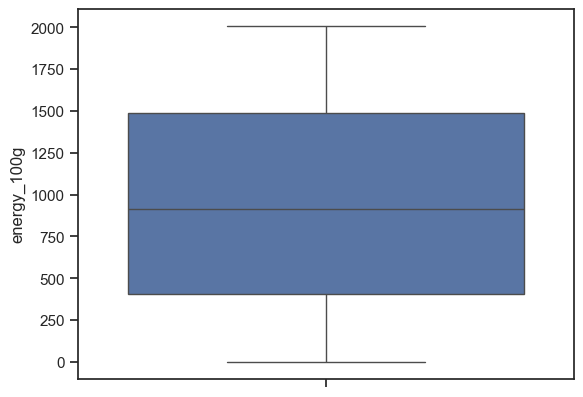

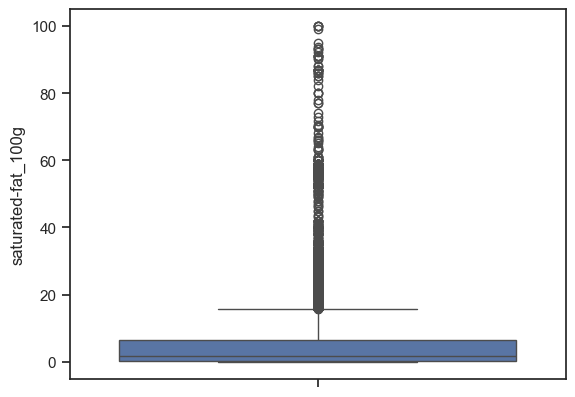

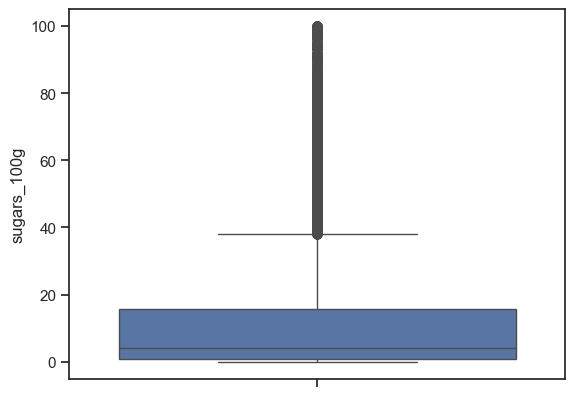

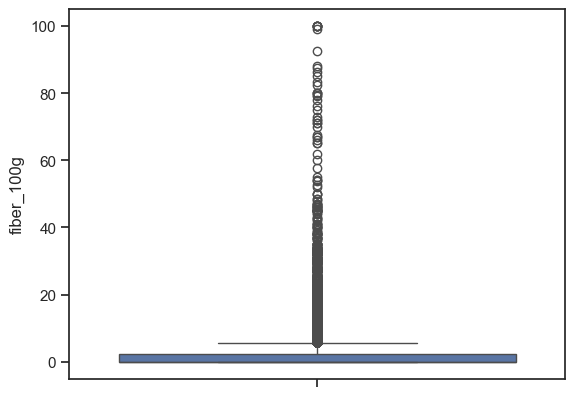

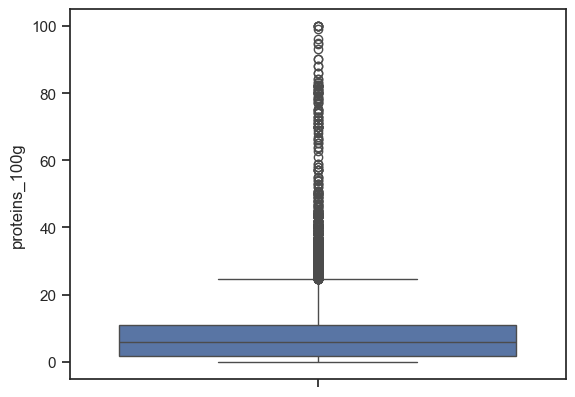

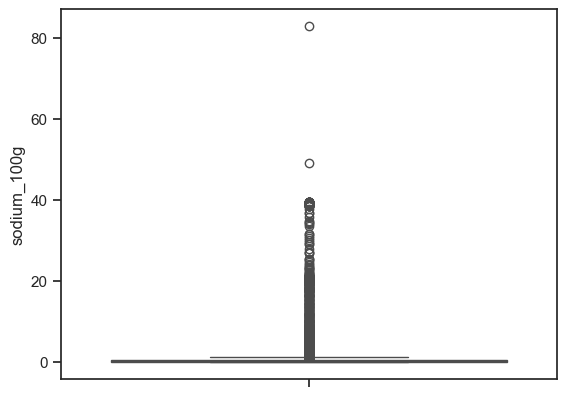

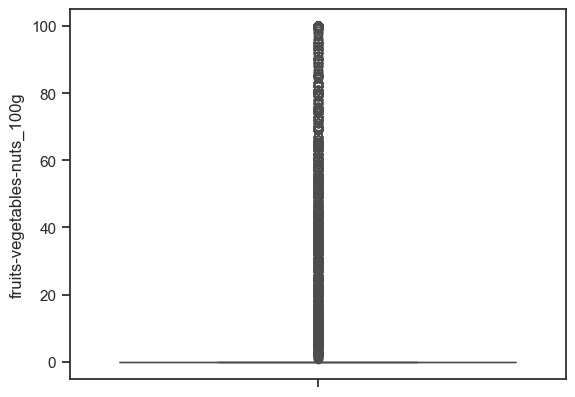

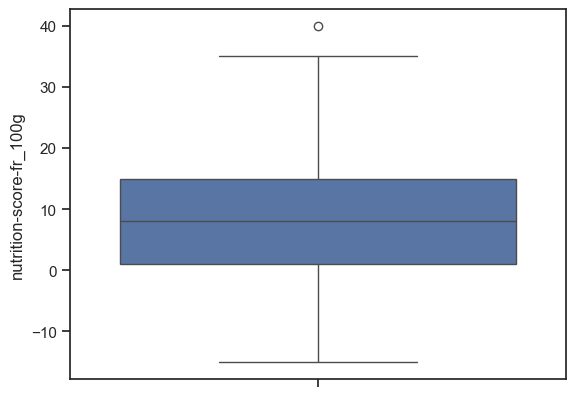

In [92]:
# Analyse descriptive des variables quantitatives

# Sélection des variables quantitatives
quant_vars = final_data.select_dtypes(include='float64')

# Tracé des boxplots pour chaque variable quantitative avec Seaborn
sns.set(style="ticks")
for var in quant_vars:
    sns.boxplot(y=var, data=quant_vars)
    plt.show()

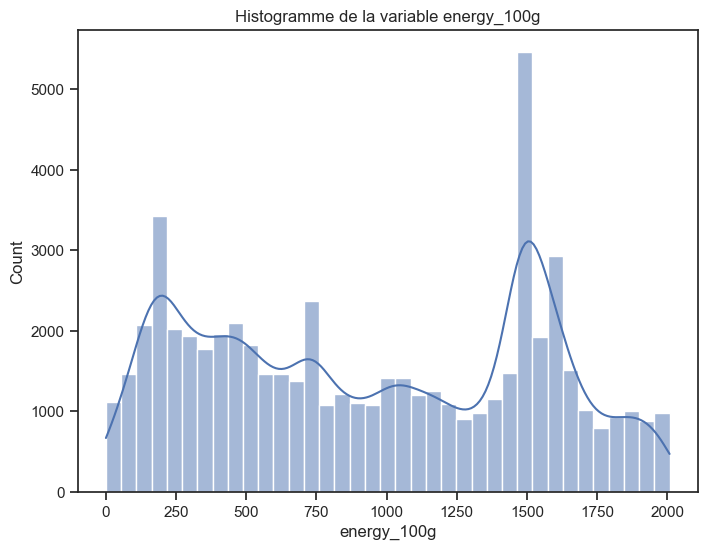

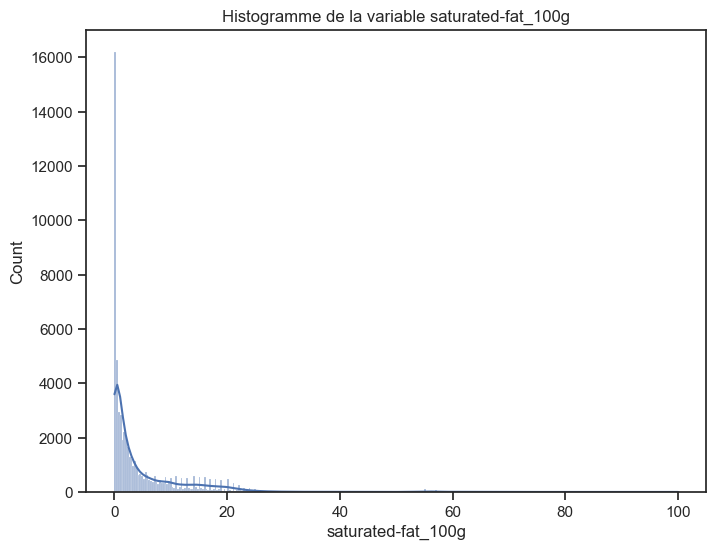

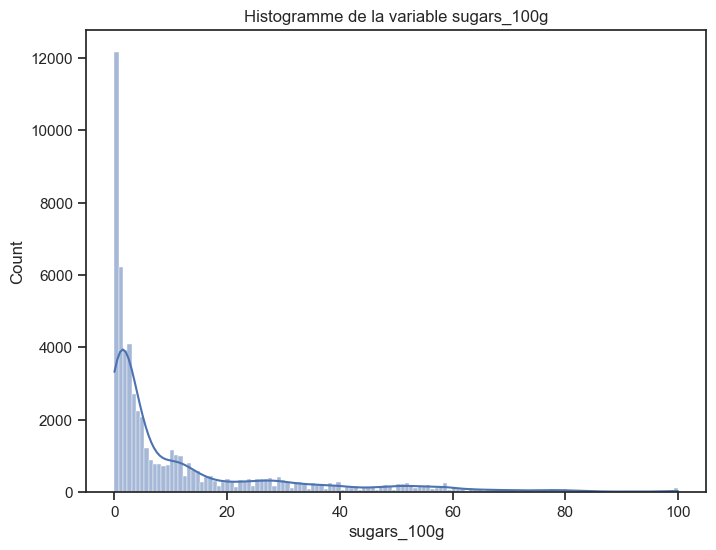

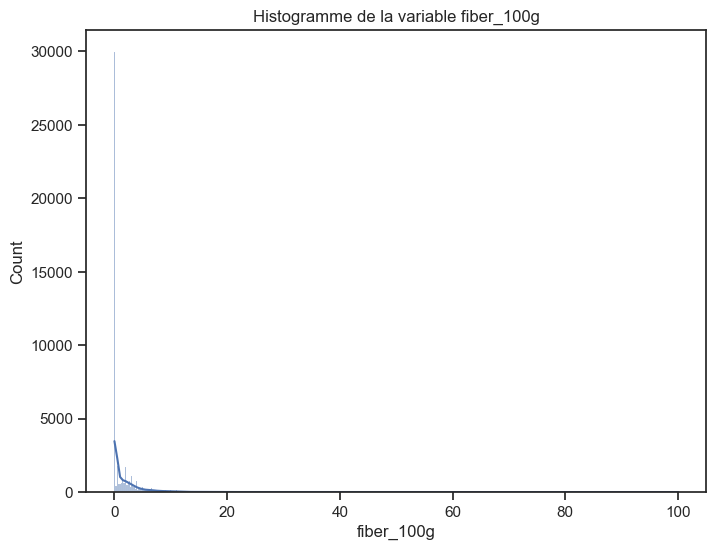

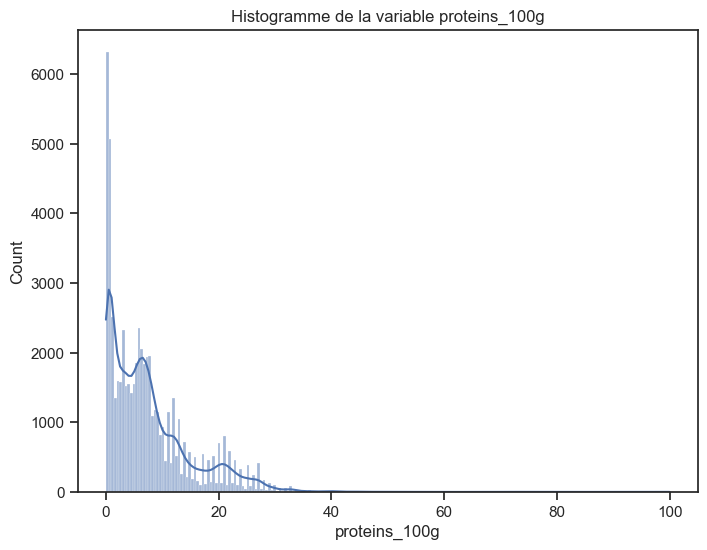

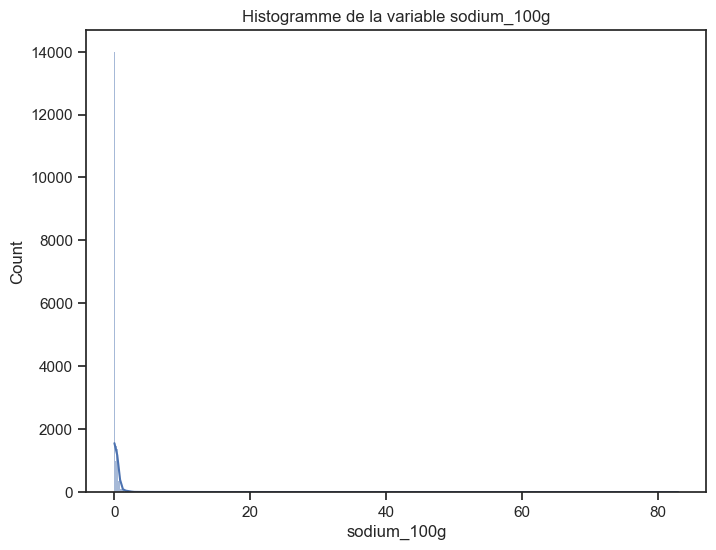

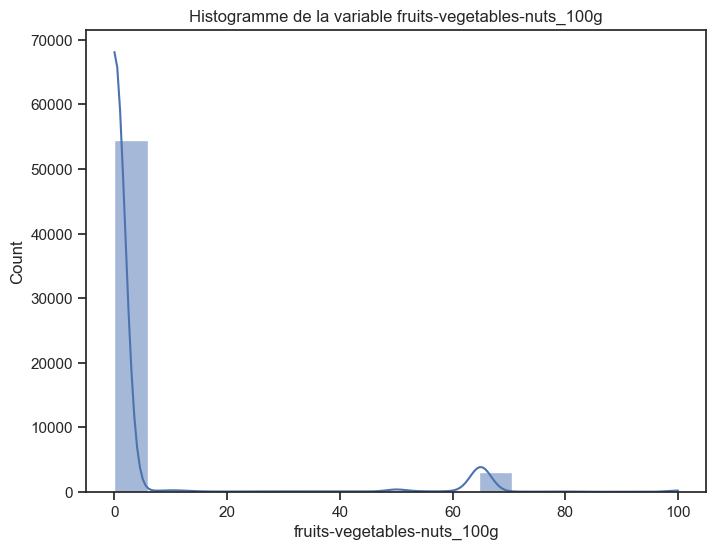

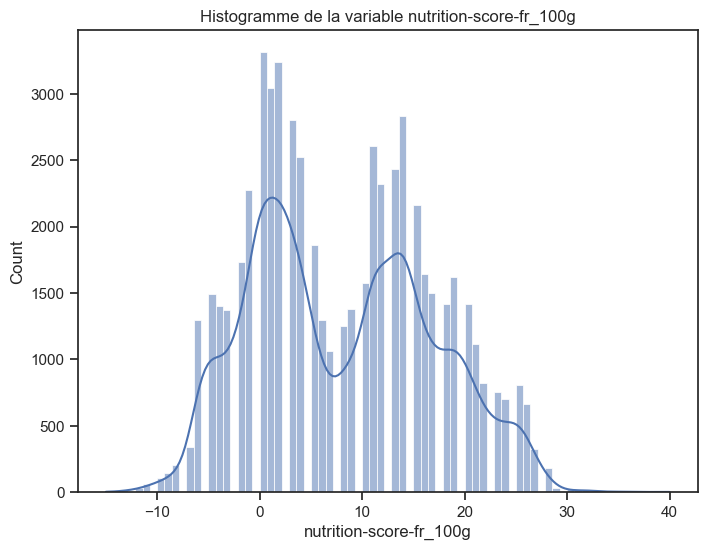

In [93]:
# Création d'un histogramme et d'un test de normalité pour chaque variable
for column in quant_vars:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=final_data, x=column, kde=True)
    plt.title(f"Histogramme de la variable {column}")
    plt.show()

'''Nous observons à travers les histogrammes qu'aucune des varaibles ne présente une distribution normale.
Initions des tests statistiques de normalité afin de confirmer ces observations'''

In [94]:
from scipy import stats
import statsmodels.api as sm

# Niveau de signification (alpha)

quant_vars = final_data.select_dtypes(include='float64')
alpha = 0.05

# Effectuer les tests de normalité
for var in quant_vars:
    ks_test = stats.kstest(quant_vars[var], 'norm')
    ad_test = stats.anderson(quant_vars[var], dist='norm')
    dagostino_test = stats.normaltest(quant_vars[var])

# Créer un tableau pandas avec les résultats des tests
    test_results = pd.DataFrame({
    'Variable':var,
    'Nom du test': ['Kolmogorov-Smirnov', 'Anderson-Darling', "D'Agostino-Pearson"],
    'Statistique de test': [ks_test.statistic, ad_test.statistic, dagostino_test.statistic],
    'p-valeur': [ks_test.pvalue, None, dagostino_test.pvalue],
    'Normalité': ['Oui' if ks_test.pvalue > alpha else 'Non',
                  'Oui' if any(ad_test.statistic < crit_val for crit_val in ad_test.critical_values) else 'Non',
                  'Oui' if dagostino_test.pvalue > alpha else 'Non']
    })

    display(test_results)

Variable         Nom du test  Statistique de test  p-valeur Normalité
0  energy_100g  Kolmogorov-Smirnov         9.922214e-01       0.0       Non
1  energy_100g    Anderson-Darling         1.273437e+03       NaN       Non
2  energy_100g  D'Agostino-Pearson         1.154580e+06       0.0       Non

Variable         Nom du test  Statistique de test  p-valeur  \
0  saturated-fat_100g  Kolmogorov-Smirnov             0.500000       0.0   
1  saturated-fat_100g    Anderson-Darling          5974.196753       NaN   
2  saturated-fat_100g  D'Agostino-Pearson         45833.183200       0.0   

  Normalité  
0       Non  
1       Non  
2       Non

Variable         Nom du test  Statistique de test  p-valeur Normalité
0  sugars_100g  Kolmogorov-Smirnov             0.637600       0.0       Non
1  sugars_100g    Anderson-Darling          6489.575225       NaN       Non
2  sugars_100g  D'Agostino-Pearson         22893.376494       0.0       Non

Variable         Nom du test  Statistique de test  p-valeur Normalité
0  fiber_100g  Kolmogorov-Smirnov             0.500000       0.0       Non
1  fiber_100g    Anderson-Darling          8039.839474       NaN       Non
2  fiber_100g  D'Agostino-Pearson         84397.276266       0.0       Non

Variable         Nom du test  Statistique de test  p-valeur Normalité
0  proteins_100g  Kolmogorov-Smirnov             0.715929       0.0       Non
1  proteins_100g    Anderson-Darling          2384.778337       NaN       Non
2  proteins_100g  D'Agostino-Pearson         31562.007844       0.0       Non

Variable         Nom du test  Statistique de test  p-valeur Normalité
0  sodium_100g  Kolmogorov-Smirnov             0.500000       0.0       Non
1  sodium_100g    Anderson-Darling         13422.454599       NaN       Non
2  sodium_100g  D'Agostino-Pearson        120297.975353       0.0       Non

Variable         Nom du test  Statistique de test  \
0  fruits-vegetables-nuts_100g  Kolmogorov-Smirnov             0.500000   
1  fruits-vegetables-nuts_100g    Anderson-Darling         19758.569923   
2  fruits-vegetables-nuts_100g  D'Agostino-Pearson         41364.974175   

   p-valeur Normalité  
0       0.0       Non  
1       NaN       Non  
2       0.0       Non

Variable         Nom du test  Statistique de test  p-valeur  \
0  nutrition-score-fr_100g  Kolmogorov-Smirnov             0.693178       0.0   
1  nutrition-score-fr_100g    Anderson-Darling           599.226412       NaN   
2  nutrition-score-fr_100g  D'Agostino-Pearson          8273.143263       0.0   

  Normalité  
0       Non  
1       Non  
2       Non

'''Les tests effectués ci-dessus confirment bien nos observations d'absence de distribution normale au niveau des varaibles'''

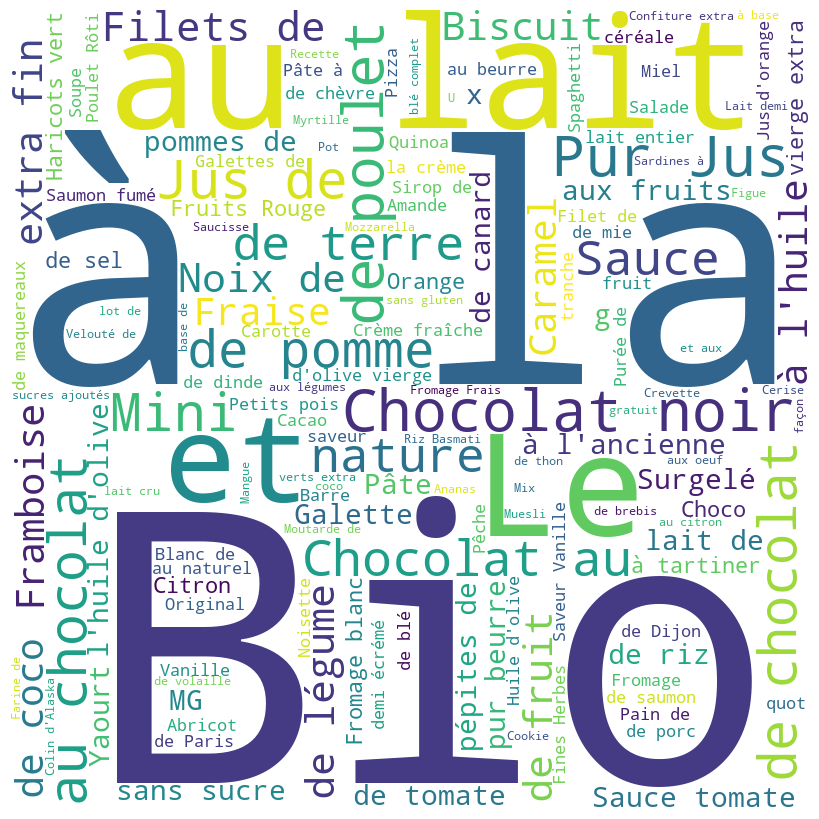

In [95]:
## Analyse de la description des produits: Quels sont les produits ou termes à forte récurrence dans la liste des produits?

from wordcloud import WordCloud

# Concaténer toutes les chaînes de caractères dans la variable 'product_name' en une seule chaîne
text = ' '.join(data['product_name'])

# Générer le word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# Afficher le word cloud
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [96]:
# Analyses bivariées

In [97]:
# Tableau des correlations (corrélation de pearson)

corr = round(final_data.drop(columns=['nutrition_grade_fr'],axis=[1]).corr(),2)
corr

energy_100g  saturated-fat_100g  sugars_100g  \
energy_100g                         1.00                0.36         0.39   
saturated-fat_100g                  0.36                1.00         0.06   
sugars_100g                         0.39                0.06         1.00   
fiber_100g                          0.21               -0.02         0.03   
proteins_100g                       0.32                0.18        -0.26   
sodium_100g                        -0.00                0.01        -0.08   
fruits-vegetables-nuts_100g        -0.26               -0.15         0.01   
nutrition-score-fr_100g             0.54                0.60         0.44   

                             fiber_100g  proteins_100g  sodium_100g  \
energy_100g                        0.21           0.32        -0.00   
saturated-fat_100g                -0.02           0.18         0.01   
sugars_100g                        0.03          -0.26        -0.08   
fiber_100g                         1.00           0.13         0.00   
proteins_100g                      0.13           1.00         0.10   
sodium_100g                        0.00           0.10         1.00   
fruits-vegetables-nuts_100g        0.03          -0.19        -0.05   
nutrition-score-fr_100g           -0.17           0.11         0.12   

                             fruits-vegetables-nuts_100g  \
energy_100g                                        -0.26   
saturated-fat_100g                                 -0.15   
sugars_100g                                         0.01   
fiber_100g                                          0.03   
proteins_100g                                      -0.19   
sodium_100g                                        -0.05   
fruits-vegetables-nuts_100g                         1.00   
nutrition-score-fr_100g                            -0.29   

                             nutrition-score-fr_100g  
energy_100g                                     0.54  
saturated-fat_100g                              0.60  
sugars_100g                                     0.44  
fiber_100g                                     -0.17  
proteins_100g                                   0.11  
sodium_100g                                     0.12  
fruits-vegetables-nuts_100g                    -0.29  
nutrition-score-fr_100g                         1.00

# Test de corrélation de Pearson

Hypothèses :
- H0(hypothèse nulle) : Il n'y a pas de corrélation linéaire entre les deux variables.
- H1(hypothèse alternative) : Il y a une corrélation linéaire entre les deux variables.

Conditions d'utilisation (corrélation de pearson):
- Les deux variables sont quantitatives et mesurées sur une échelle continue.
- La relation entre les deux variables est linéaire
- Les deux variables suivent une distribution normale.

Les variables ne suivant par une distribution normale, le coefficient de corrélation de pearson n'est pas approprié pour analyser les corrélation entre elles.

# Test de corrélation de Spearman

Hypothèses :
- H0 : Il n'y a pas de corrélation monotone entre les deux variables.
- H1 : Il y a une corrélation monotone entre les deux variables.

Conditions d'utilisation :
- Les deux variables sont quantitatives ou ordinales.
- Les données n'ont pas besoin d'être normalement distribuées.
- La relation entre les variables peut être monotone (linéaire ou non linéaire).

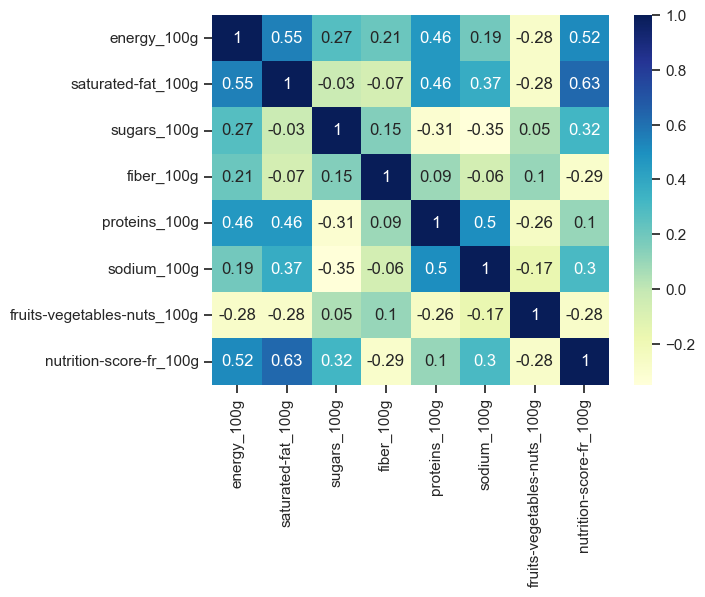

In [98]:
corr_matrix = round(final_data.drop(columns=['nutrition_grade_fr'],axis=[1]).corr(method='spearman'),2)

# Calcul des p-values pour chaque paire de variables
# fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(corr_matrix,annot=True,cmap="YlGnBu")
plt.show()

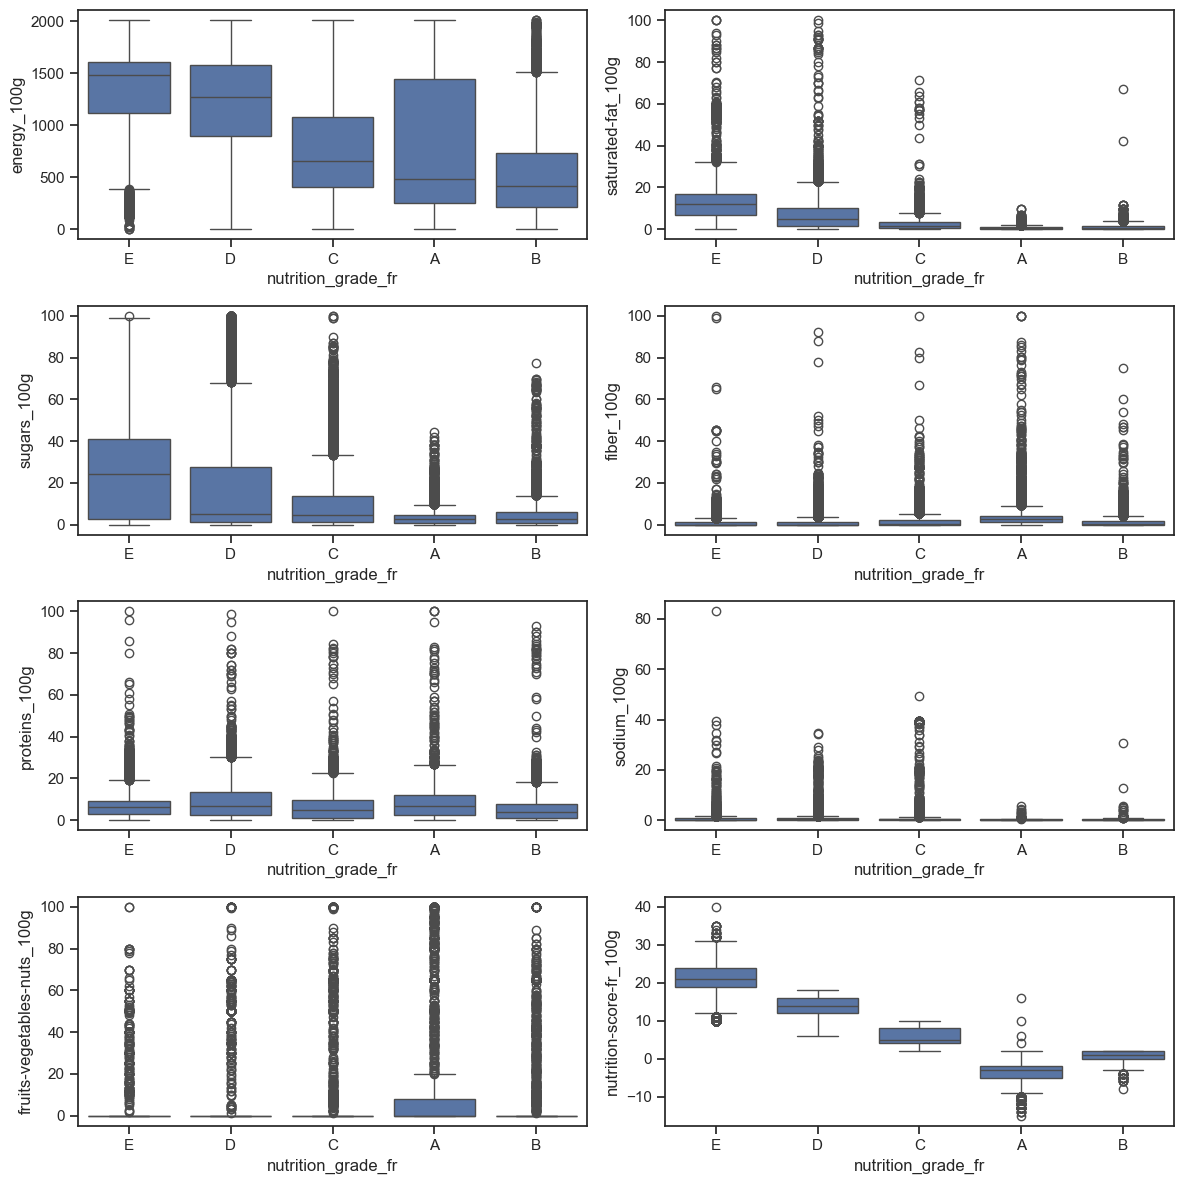

In [99]:
#Analyse des relations entre les variables et le nutrition_grade des produits

# Création des boxplots pour chaque variable en fonction du nutrition_grade des produits
fig,ax = plt.subplots(nrows = 4, ncols=2, figsize=(12,12))
row = 0
col = 0
for i in range(len(final_data.columns) -1):
    if col > 1:
        row += 1
        col = 0
    axes = ax[row,col]
    sns.boxplot(x = final_data['nutrition_grade_fr'], y = final_data[final_data.columns[i]], ax = axes)
    col += 1
plt.tight_layout()
plt.show()

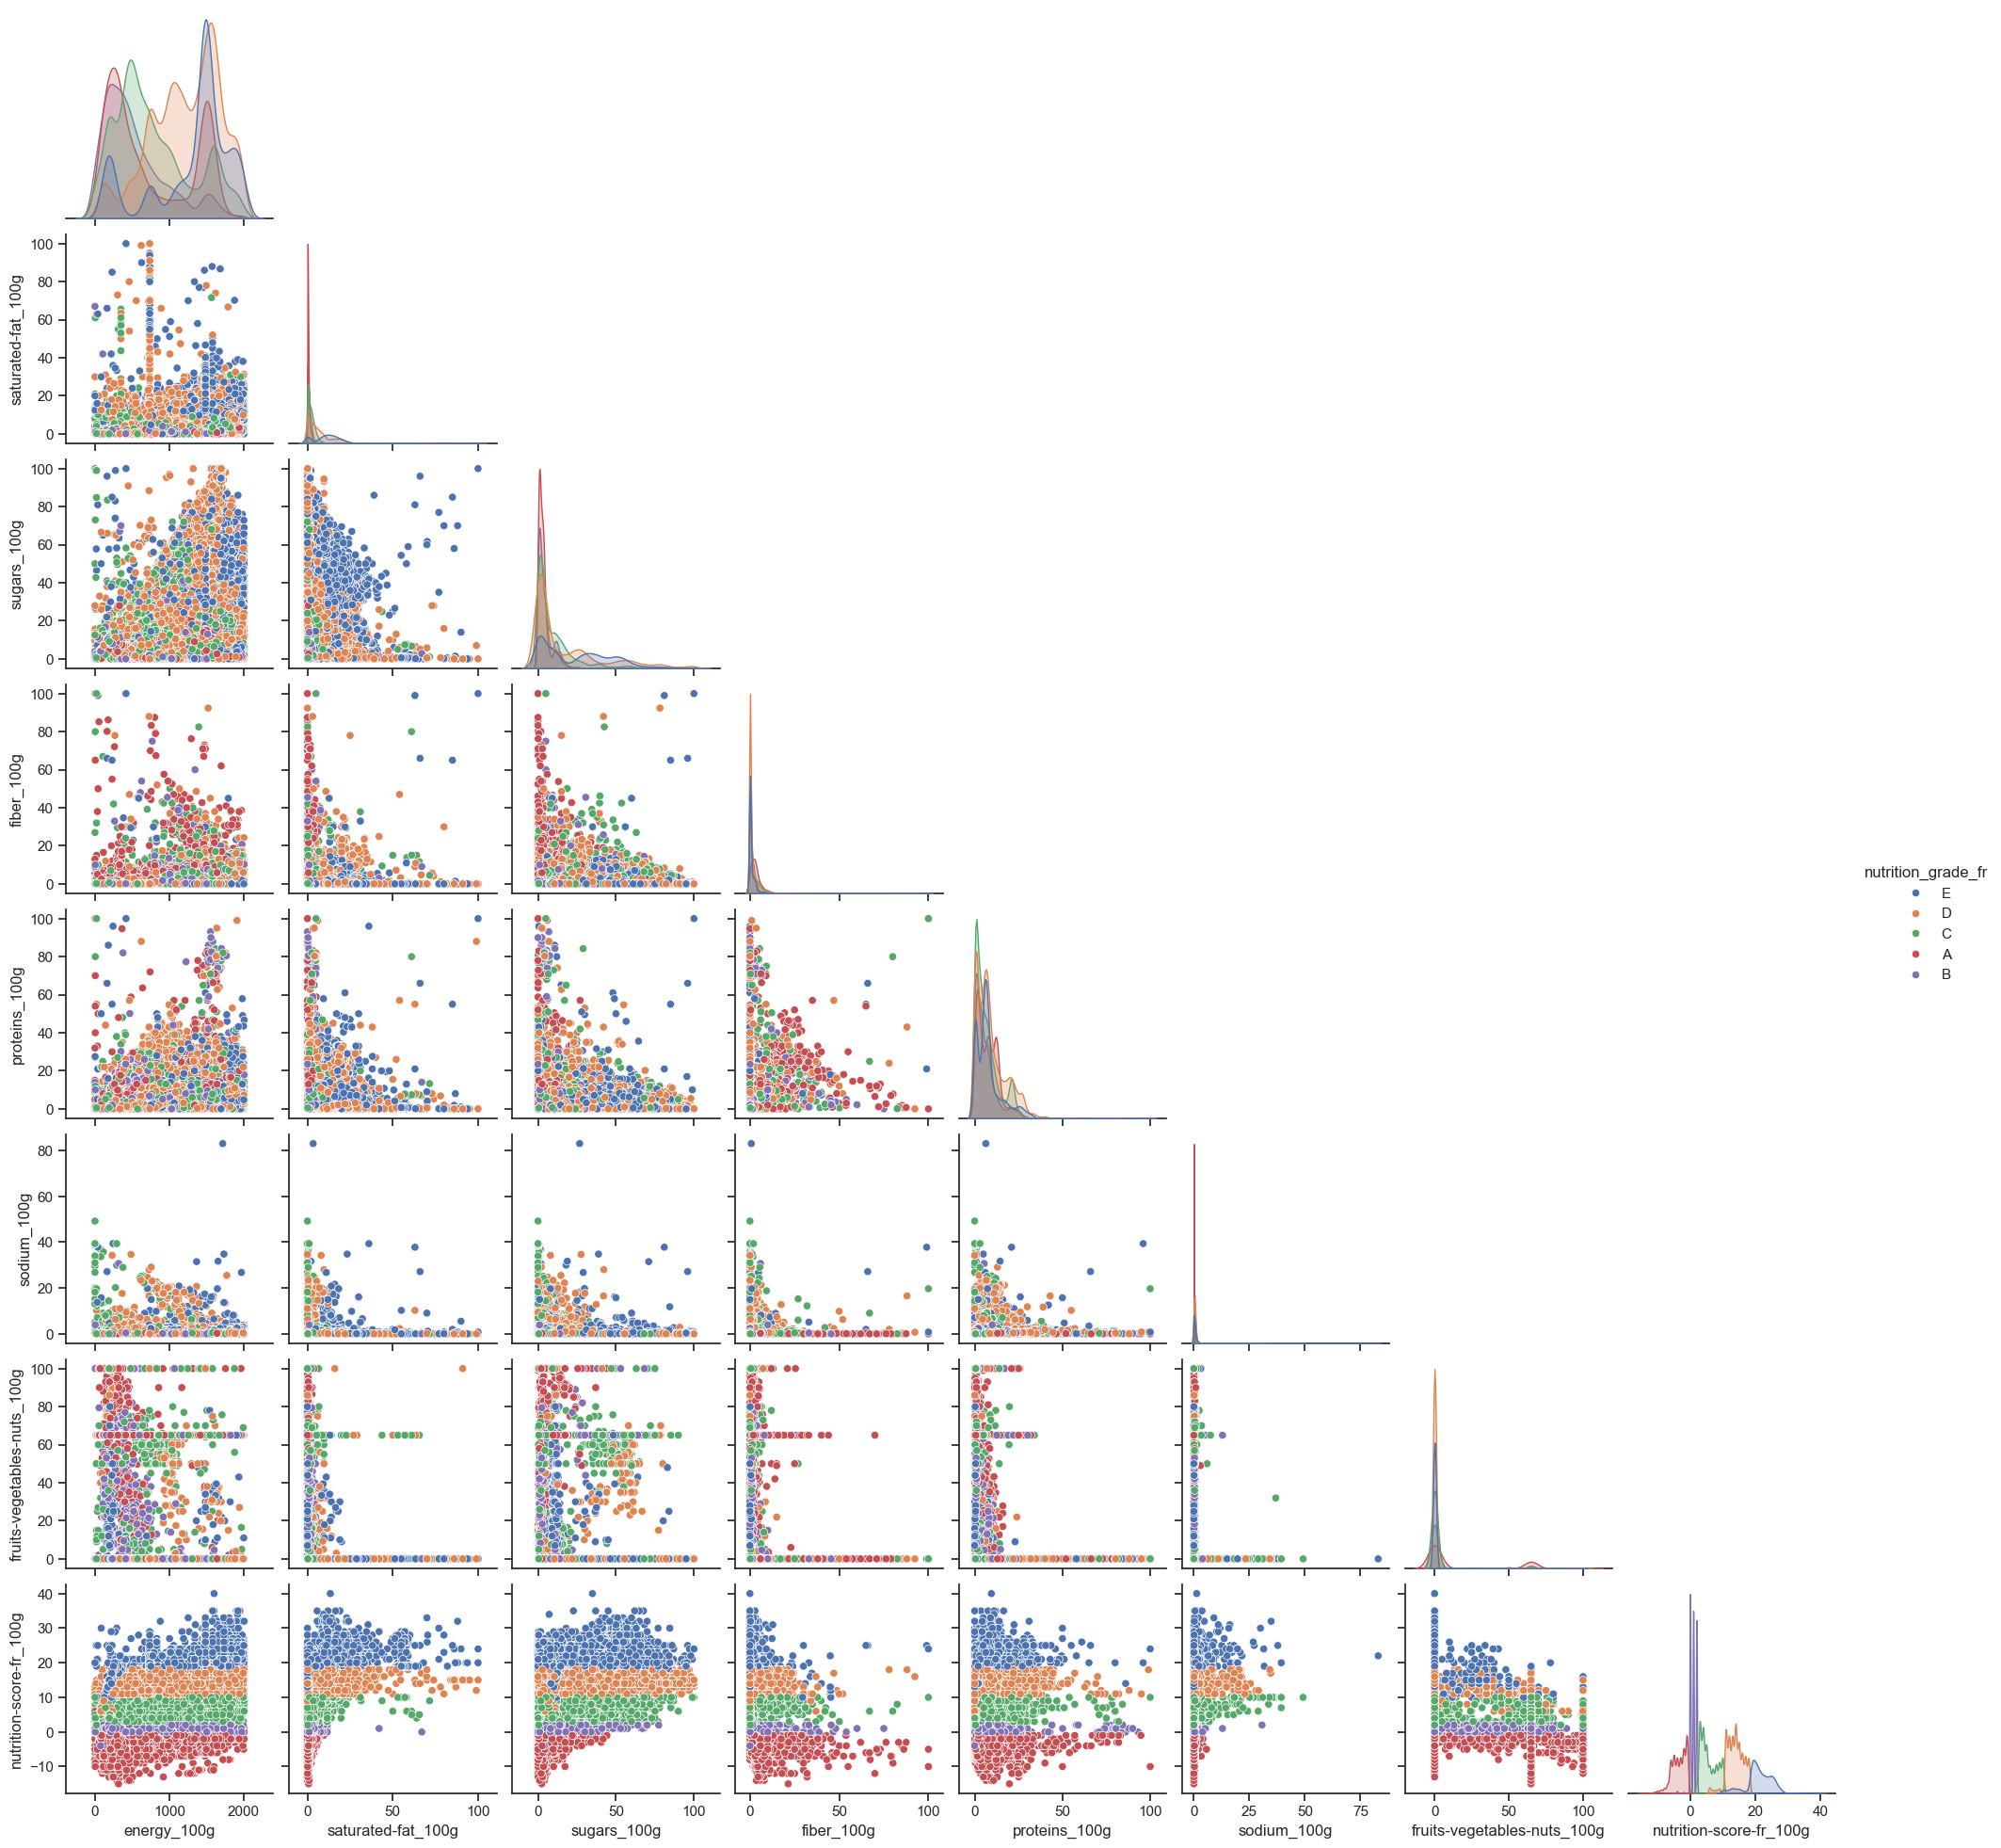

In [100]:
# pairplot

p=sns.pairplot(final_data, hue = 'nutrition_grade_fr', corner=True)

In [101]:
# Confirmation de l'absence des liaisons avec un test de Kruskal-Wallis pour chaque variable

for column in final_data.columns[:-1]:
    _, p_value = stats.kruskal(*[final_data[column][final_data.nutrition_grade_fr == grade] for grade in final_data.nutrition_grade_fr.unique()])
    if p_value < 0.05:
        print(f"La variable {column} est significativement différente entre les grades (p-value={p_value})")
    else:
        print(f"La variable {column} n'est pas significativement différente entre les grades (p-value={p_value})")

La variable energy_100g est significativement différente entre les grades (p-value=0.0)
La variable saturated-fat_100g est significativement différente entre les grades (p-value=0.0)
La variable sugars_100g est significativement différente entre les grades (p-value=0.0)
La variable fiber_100g est significativement différente entre les grades (p-value=0.0)
La variable proteins_100g est significativement différente entre les grades (p-value=5.931728993061146e-288)
La variable sodium_100g est significativement différente entre les grades (p-value=0.0)
La variable fruits-vegetables-nuts_100g est significativement différente entre les grades (p-value=0.0)
La variable nutrition-score-fr_100g est significativement différente entre les grades (p-value=0.0)


# ANOVA (Analysis of Variance)

Hypothèses :
- H0 (hypothèse nulle): Les moyennes de tous les groupes sont égales.
- H1 (hypothèse alternative): Au moins une des moyennes des groupes est différente des autres.

Conditions d'utilisation :
- La variable quantitative est normalement distribuée dans chaque groupe.
- Les variances des groupes sont égales.
- Les observations sont indépendantes.

Interprétation :
- Si la p-valeur est inférieure au seuil de significativité (généralement 0,05), on rejette l'hypothèse nulle et on conclut qu'au moins une des moyennes des groupes est significativement différente des autres.
- Si la p-valeur est inférieure au seuil de significativité (généralement 0,05), on rejette l'hypothèse nulle et on conclut que les distributions des deux groupes sont significativement différentes.


In [102]:
# Séparation les données en groupes en fonction du grade

grade_A = final_data[final_data['nutrition_grade_fr'] == 'A']['nutrition-score-fr_100g']
grade_B = final_data[final_data['nutrition_grade_fr'] == 'B']['nutrition-score-fr_100g']
grade_C = final_data[final_data['nutrition_grade_fr'] == 'C']['nutrition-score-fr_100g']
grade_D = final_data[final_data['nutrition_grade_fr'] == 'D']['nutrition-score-fr_100g']
grade_E = final_data[final_data['nutrition_grade_fr'] == 'E']['nutrition-score-fr_100g']

# Vérifier la normalité des groupes de la variable quantitative à l'aide du test de Kolmogorov-Smirnov

grade_A_p_value = stats.kstest(grade_A,'norm').pvalue
grade_B_p_value = stats.kstest(grade_B,'norm').pvalue
grade_C_p_value = stats.kstest(grade_C,'norm').pvalue
grade_D_p_value = stats.kstest(grade_D,'norm').pvalue
grade_E_p_value = stats.kstest(grade_E,'norm').pvalue

print("P-valeur de la normalité (Kolmogorov-Smirnov) - grade A :", grade_A_p_value)
print("P-valeur de la normalité (Kolmogorov-Smirnov) - grade B :", grade_B_p_value)
print("P-valeur de la normalité (Kolmogorov-Smirnov) - grade C :", grade_C_p_value)
print("P-valeur de la normalité (Kolmogorov-Smirnov) - grade D :", grade_D_p_value)
print("P-valeur de la normalité (Kolmogorov-Smirnov) - grade E :", grade_E_p_value)

P-valeur de la normalité (Kolmogorov-Smirnov) - grade A : 0.0
P-valeur de la normalité (Kolmogorov-Smirnov) - grade B : 0.0
P-valeur de la normalité (Kolmogorov-Smirnov) - grade C : 0.0
P-valeur de la normalité (Kolmogorov-Smirnov) - grade D : 0.0
P-valeur de la normalité (Kolmogorov-Smirnov) - grade E : 0.0


'''Nous constatons qu'aucun des groupes définis n'est normalement distribué'''

In [103]:
# ANOVA

from scipy.stats import f_oneway

anova_stat, anova_p_value = f_oneway(grade_A, grade_B, grade_C, grade_D, grade_E)
print("Statistique F de l'ANOVA :", anova_stat)
print("P-valeur (ANOVA) :", anova_p_value)

Statistique F de l'ANOVA : 149574.5957906629
P-valeur (ANOVA) : 0.0


'''Au vue des résultats, l'hypothèse H0 est rejetée,les moyennes des groupes ne sont pas égales'''

# Analyse multivariée avec l'ACP

## Construction de l'ACP

In [104]:
# Importation des packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [105]:
# Séparation des données en variables explicatives (X) et variable qualitative (Y)
X = final_data.iloc[:, :-1].values
y = final_data.iloc[:, -1].values

In [106]:
X.shape

(59249, 8)

In [107]:
# Standardisation des données
# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [108]:
# Réduction de dimension
pca = PCA()
X_pca=pca.fit_transform(X_scaled)

#### Aide à l'interpretation

### Choix du nombre d'axes

In [109]:
# Analyse des valeurs propres
comp = pd.DataFrame({
        "Dimension" : ["Dim" + str(x + 1) for x in range(8)], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)},
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"])
comp

Dimension  Valeur propre  % variance expliquée  % cum. var. expliquée
0      Dim1       2.399635                  30.0                   30.0
1      Dim2       1.404957                  18.0                   48.0
2      Dim3       1.173590                  15.0                   62.0
3      Dim4       0.960576                  12.0                   74.0
4      Dim5       0.855542                  11.0                   85.0
5      Dim6       0.656404                   8.0                   93.0
6      Dim7       0.333339                   4.0                   97.0
7      Dim8       0.216092                   3.0                  100.0

Text(4.0, 13, '12.5%')

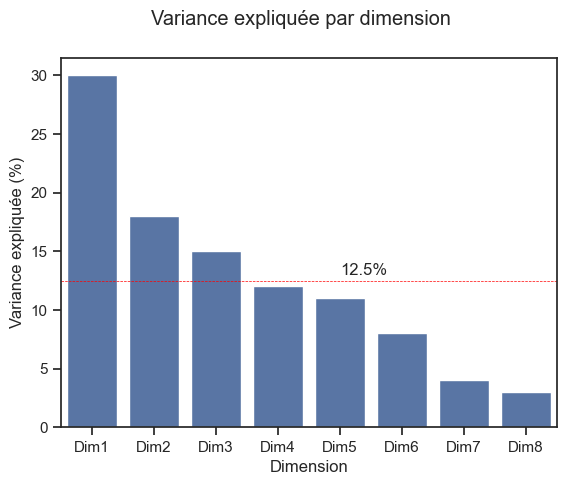

In [110]:
# Scree plot pour choisir le nombre de composantes principales
g_comp = sns.barplot(x = "Dimension", 
                y = "% variance expliquée",
                data = comp)
g_comp.set(ylabel = "Variance expliquée (%)")
g_comp.figure.suptitle("Variance expliquée par dimension")
plt.axhline(y = 12.5, linewidth = .5, color = "red", linestyle = "--") # 12.5 = 100 / 8 (nb dimensions)
plt.text(4.0, 13, "12.5%")

# Observation sur le choix du nombre d’axes

Nous constatons que pour expliquer la totalité de la variance il faut 8 dimensions
En analysant les valeurs propres, nous constatons qu’avec 4 dimensions, nous parvenons à expliquer 74% de la variance
Le scree plot de la variance expliquée par dimension (Eboulis des valeurs propres) montre un coude à partir de la 4ème dimension. Nous retenons donc 4 dimensions pour nos analyses.

In [111]:
# Calcul du cosinus carré des variables
cos_squared = np.square(pca.components_)

# Création d'un dataframe pandas avec le cosinus carré des variables
final_data_cos_squared = pd.DataFrame(cos_squared, columns=['PC{}'.format(i+1) for i in range(X.shape[1])])
final_data_cos_squared.index = final_data.columns[:-1]

display(final_data_cos_squared)

PC1       PC2       PC3       PC4       PC5  \
energy_100g                  0.268220  0.198260  0.087211  0.000473  0.043876   
saturated-fat_100g           0.001080  0.003930  0.358456  0.050582  0.417035   
sugars_100g                  0.105393  0.038820  0.065795  0.619039  0.008804   
fiber_100g                   0.000120  0.023195  0.041211  0.042205  0.018832   
proteins_100g                0.002616  0.293885  0.035210  0.000768  0.017300   
sodium_100g                  0.071025  0.234166  0.059631  0.214828  0.313565   
fruits-vegetables-nuts_100g  0.537511  0.007468  0.212284  0.030054  0.176904   
nutrition-score-fr_100g      0.014034  0.200277  0.140202  0.042051  0.003682   

                                  PC6       PC7       PC8  
energy_100g                  0.003470  0.083097  0.315394  
saturated-fat_100g           0.071889  0.066363  0.030664  
sugars_100g                  0.081515  0.030465  0.050169  
fiber_100g                   0.819573  0.050331  0.004533  
proteins_100g                0.003235  0.640174  0.006814  
sodium_100g                  0.000846  0.105808  0.000130  
fruits-vegetables-nuts_100g  0.001981  0.008480  0.025317  
nutrition-score-fr_100g      0.017492  0.015282  0.566979

In [112]:
# Contribution à la formation de l'axe
# Obtenir les composantes principales
components = pca.components_

n_components = X.shape[1]
feature_names=final_data.columns[0:8]
# Calculer la contribution des variables à la formation des axes
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
variable_contributions = (loadings**2) * eigenvalues

# Créer un DataFrame pour faciliter l'affichage des résultats
column_names = [f'PC{i+1}_contrib' for i in range(n_components)]
variable_contrib_final_data = pd.DataFrame(variable_contributions, columns=column_names, index=feature_names)

display(variable_contrib_final_data)

PC1_contrib  PC2_contrib  PC3_contrib  \
energy_100g                     0.643630     0.001518     0.123689   
saturated-fat_100g              0.475751     0.005521     0.045559   
sugars_100g                     0.209274     0.503616     0.077216   
fiber_100g                      0.001135     0.071066     0.726498   
proteins_100g                   0.105286     0.585917     0.010332   
sodium_100g                     0.008327     0.101001     0.095665   
fruits-vegetables-nuts_100g     0.199402     0.093237     0.035753   
nutrition-score-fr_100g         0.756829     0.043082     0.058878   

                             PC4_contrib  PC5_contrib  PC6_contrib  \
energy_100g                     0.000115     0.002238     0.046621   
saturated-fat_100g              0.022280     0.251431     0.153708   
sugars_100g                     0.039587     0.030124     0.039142   
fiber_100g                      0.040541     0.000657     0.141014   
proteins_100g                   0.018090     0.014801     0.205826   
sodium_100g                     0.787262     0.002767     0.000555   
fruits-vegetables-nuts_100g     0.048347     0.547696     0.069453   
nutrition-score-fr_100g         0.004354     0.005829     0.000085   

                             PC7_contrib  PC8_contrib  
energy_100g                     0.179173     0.003033  
saturated-fat_100g              0.002490     0.043278  
sugars_100g                     0.070763     0.030297  
fiber_100g                      0.010018     0.009087  
proteins_100g                   0.058969     0.000796  
sodium_100g                     0.000660     0.003780  
fruits-vegetables-nuts_100g     0.002827     0.003302  
nutrition-score-fr_100g         0.008439     0.122520

In [113]:
# Calculer la contribution des variables à la formation des axes
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
variable_contributions = (loadings**2) * eigenvalues

# Convertir les contributions en pourcentage
variable_contrib_percent = variable_contributions / eigenvalues * 100

# Créer un DataFrame pour faciliter l'affichage des résultats
column_names = [f'PC{i+1}_contrib' for i in range(n_components)]
variable_contrib_final_data = pd.DataFrame(variable_contrib_percent, columns=column_names, index=feature_names)

display(variable_contrib_final_data)

PC1_contrib  PC2_contrib  PC3_contrib  \
energy_100g                    26.822010     0.108028    10.539343   
saturated-fat_100g             19.825972     0.392982     3.881983   
sugars_100g                     8.721073    35.845621     6.579479   
fiber_100g                      0.047319     5.058234    61.903920   
proteins_100g                   4.387603    41.703545     0.880376   
sodium_100g                     0.346996     7.188878     8.151493   
fruits-vegetables-nuts_100g     8.309675     6.636304     3.046503   
nutrition-score-fr_100g        31.539353     3.066407     5.016903   

                             PC4_contrib  PC5_contrib  PC6_contrib  \
energy_100g                     0.011985     0.261552     7.102540   
saturated-fat_100g              2.319454    29.388470    23.416627   
sugars_100g                     4.121124     3.520985     5.963104   
fiber_100g                      4.220505     0.076786    21.482807   
proteins_100g                   1.883234     1.730030    31.356550   
sodium_100g                    81.957252     0.323452     0.084598   
fruits-vegetables-nuts_100g     5.033132    64.017357    10.580775   
nutrition-score-fr_100g         0.453314     0.681369     0.012999   

                             PC7_contrib  PC8_contrib  
energy_100g                    53.751096     1.403446  
saturated-fat_100g              0.746847    20.027665  
sugars_100g                    21.228406    14.020209  
fiber_100g                      3.005357     4.205073  
proteins_100g                  17.690426     0.368236  
sodium_100g                     0.198106     1.749224  
fruits-vegetables-nuts_100g     0.848018     1.528237  
nutrition-score-fr_100g         2.531745    56.697911

# Observation sur la contribution des variables aux axes :

Les variables energy_100g , nutrition-score-fr_100g contribuent bien à la formation de l’axe PC1 et saturated-fat_100g aussi mais dans une moindre mesure.

Proteins_100g et sugars_100g contribuent bien à la formation de l’axe PC2

Fiber_100g contribue fortement à la formation de l’axe PC3

Sodium_100g contribue très fortement à la formation de l’axe PC4.

In [114]:
# Calculer la contribution des individus à la formation des axes
eigenvalues = pca.explained_variance_
contributions = (X_pca**2) / (X_pca.shape[0] * eigenvalues)

# Convertir les contributions en pourcentage
contrib_percent = contributions * 100

# Créer un DataFrame pour faciliter l'affichage des résultats
column_names = [f'PC{i+1}_contrib' for i in range(n_components)]
contrib_final_data = pd.DataFrame(contrib_percent, columns=column_names)

display(contrib_final_data)

PC1_contrib   PC2_contrib  PC3_contrib  PC4_contrib  PC5_contrib  \
0         0.005551  4.652138e-03     0.000684     0.000150     0.000048   
1         0.002594  1.175148e-02     0.002065     0.000906     0.003794   
2         0.000497  8.392922e-04     0.001128     0.000053     0.000610   
3         0.000453  1.159952e-04     0.000396     0.000216     0.000279   
4         0.000496  8.297088e-04     0.001141     0.000043     0.000612   
...            ...           ...          ...          ...          ...   
59244     0.000164  5.389594e-04     0.001208     0.000019     0.000115   
59245     0.000843  3.694636e-07     0.000649     0.000378     0.000281   
59246     0.001488  3.681397e-03     0.000548     0.007798     0.000311   
59247     0.000069  1.984240e-03     0.003372     0.000040     0.000446   
59248     0.002312  7.845055e-05     0.000892     0.000240     0.000539   

        PC6_contrib   PC7_contrib  PC8_contrib  
0      5.983794e-07  3.771896e-06     0.000531  
1      3.200931e-03  1.202470e-03     0.006436  
2      6.528389e-04  1.216563e-03     0.006008  
3      7.454652e-04  3.734604e-04     0.001261  
4      6.541848e-04  1.212622e-03     0.005976  
...             ...           ...          ...  
59244  2.066628e-04  4.031667e-03     0.001298  
59245  1.287951e-04  2.351683e-07     0.000234  
59246  4.200811e-03  6.365016e-03     0.000022  
59247  2.122080e-04  4.250695e-03     0.002579  
59248  1.227053e-03  4.074243e-04     0.000199  

[59249 rows x 8 columns]

# Représentation graphique et interprétation

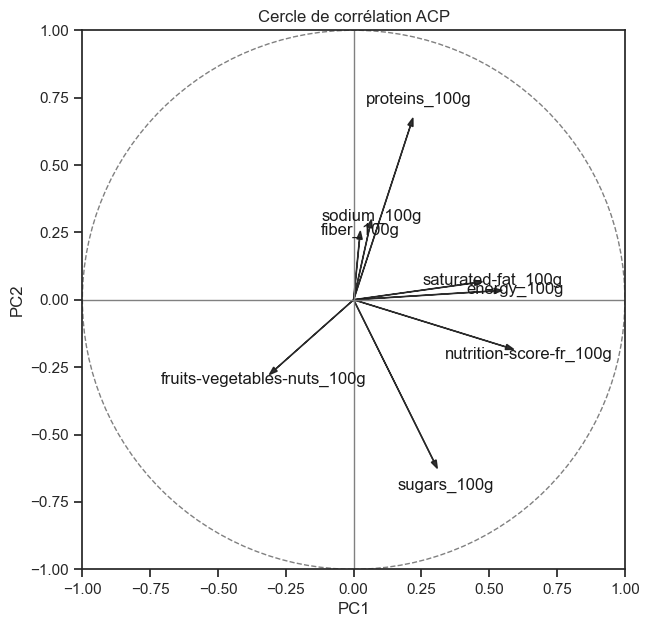

In [115]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[0:2, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
plt.figure(figsize=(7, 7))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, feature_names[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cercle de corrélation ACP')

# Afficher la figure
plt.show()

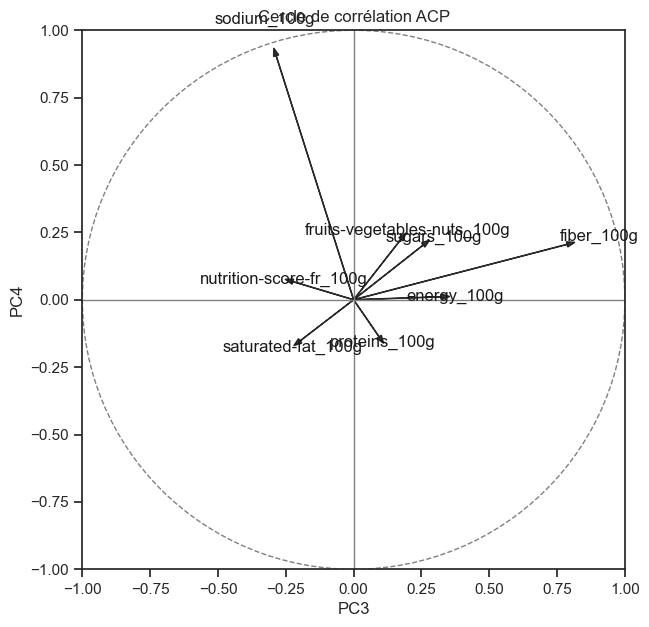

In [116]:
# Créer le cercle de corrélation
coeff = np.transpose(pca.components_[2:4, :])
n = coeff.shape[0]
xs = np.array([1, 0])
ys = np.array([0, 1])

# Créer la figure
plt.figure(figsize=(7, 7))

# Placer les vecteurs des variables
for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='k', alpha=0.9, head_width=0.02)
    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, feature_names[i], color='k', ha='center', va='center')

# Placer le cercle unitaire
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Ajuster les limites et les axes
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel('PC3')
plt.ylabel('PC4')
plt.title('Cercle de corrélation ACP')

# Afficher la figure
plt.show()

# Intépretation de l'ACP

Sur l’axe PC1 : r(energy_100g, PC1) = 0.64  r(nutrition-score-fr_100g , PC1) = 0.76
L’axe PC1 pourrait représenter les aliments à forte teneur énergétique, ils ont un nutrition-score élevé ce qui confirme ce que nous avons vu sur leur moins bon classement en grade dans l’analyse bivariée.

Sur l’axe PC2 : r(proteins_100g , PC2) = 0.6  r(sugars_100g , PC2) = -0.5 
L’axe PC2 pourrait représenter les aliments riches en protéines et faibles en sucre

Sur l’axe PC3 : r(fiber_100g , PC3) = 0.73
L’axe PC3 pourrait représenter les aliments riches en fibres

Sur l’axe PC4 : r(sodium_100g , PC4) = 0.78
L’axe PC4 pourrait représenter les aliments à forte teneur en sel.